# Telecom Churn Case Study

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('telecom_churn_data.csv')

In [3]:
data.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109             0.0             0.0             0.0   
1     7001865778        109             0.0             0.0             0.0   
2     7001625959        109             0.0             0.0             0.0   
3     7001204172        109             0.0             0.0             0.0   
4     7000142493        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9   arpu_6  ...  sachet_3g_9  fb_user_6  fb_user_7  \
0            9/30/2014  197.385  ...            0        1.0        1.0   
1            9/30/2014   34.047  ...            0        NaN        1.0   
2            9/30/2014  167.690  ...            0        NaN        NaN   
3            9/30/2014  221.338  ...            0        NaN        NaN   
4            9/30/2014  261.636  ...            0        0.0        NaN   

   fb_user_8  fb_user_9   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  sep_vbc_3g  
0        1.0        NaN   968        30.4         0.0      101.20        3.58  
1        1.0        NaN  1006         0.0         0.0        0.00        0.00  
2        NaN        1.0  1103         0.0         0.0        4.17        0.00  
3        NaN        NaN  2491         0.0         0.0        0.00        0.00  
4        NaN        NaN  1526         0.0         0.0        0.00        0.00  

[5 rows x 226 columns]

In [4]:
data.info('All')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 226 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    mobile_number             int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    last_date_of_month_9      object 
 9    arpu_6                    float64
 10   arpu_7                    float64
 11   arpu_8                    float64
 12   arpu_9                    float64
 13   onnet_mou_6               float64
 14   onnet_mou_7               float64
 15   onnet_mou_8               float64
 16   onnet_mou_9               float64
 17   offnet_mou_6              float64
 18   offnet_mou_7              float64
 19   offnet_mou_8              float64
 20   offn

In [5]:
data.shape

(99999, 226)

### Data Cleaning

In [6]:
#Checking for null values
data.isnull().sum()

mobile_number        0
circle_id            0
loc_og_t2o_mou    1018
std_og_t2o_mou    1018
loc_ic_t2o_mou    1018
                  ... 
aon                  0
aug_vbc_3g           0
jul_vbc_3g           0
jun_vbc_3g           0
sep_vbc_3g           0
Length: 226, dtype: int64

In [7]:
def nulls(x):
    return x.isnull().sum()/len(x)*100

In [8]:
null_perc = nulls(data)

In [9]:
null_perc.sort_values(ascending=False)

arpu_3g_6            74.846748
night_pck_user_6     74.846748
total_rech_data_6    74.846748
arpu_2g_6            74.846748
max_rech_data_6      74.846748
                       ...    
max_rech_amt_7        0.000000
max_rech_amt_6        0.000000
total_rech_amt_9      0.000000
total_rech_amt_8      0.000000
sep_vbc_3g            0.000000
Length: 226, dtype: float64

In [10]:
#Dropping columns with null values above 50% except any columns with rech_amt and rech_data,
#Since it will be used for filtering the records using the average recharge amount.
drop = null_perc[null_perc > 50]
dropCols = drop[~drop.index.str.contains('rech_amt|rech_data')].index

In [11]:
data.drop(dropCols,axis=1,inplace=True)
data.shape

(99999, 202)

In [12]:
null_perc[null_perc > 0].shape

(166,)

**Since there are 166 columns with null values, lets first filter high value customers and then again check for null values.**

* According to the business requirement, it is necassary to filter customers with avg reacharge in the good phase above the 70th percentile.
* Following steps are followed to derive the average recharge amount in the good phase:
    1. Create columns for total reacharge amount for data using avg_rech_amt_data and total_rech_data columns of month 6 anf 7
    2. Create columns with the mean values of total recharge amount for call and data for month 6 and 7
    3. Filter data using the newly created colum with average values of amount in the good phase


In [13]:
#Converting null values in recharge amount and data column to 0.
data['total_rech_data_6'] = data['total_rech_data_6'].replace(np.NaN,0)
data['total_rech_data_7'] = data['total_rech_data_7'].replace(np.NaN,0)
data['av_rech_amt_data_6'] = data['av_rech_amt_data_6'].replace(np.NaN,0)
data['av_rech_amt_data_7'] = data['av_rech_amt_data_7'].replace(np.NaN,0)
data['total_rech_amt_6'] = data['total_rech_amt_6'].replace(np.NaN,0)
data['total_rech_amt_7'] = data['total_rech_amt_7'].replace(np.NaN,0)

In [14]:
#Deriving total recharge amount for data
data['total_data_amt_6'] = data['total_rech_data_6']*data['av_rech_amt_data_6']
data['total_data_amt_7'] = data['total_rech_data_7']*data['av_rech_amt_data_7']

In [15]:
#Creating column with avg values of total amount in spent on recharge by the customer in good phase
data['avg_rech_amt_gh'] = data[['total_data_amt_6','total_data_amt_7','total_rech_amt_6','total_rech_amt_7']].mean(axis=1)

In [16]:
data['avg_rech_amt_gh'].quantile(0.7)

239.0

In [17]:
#Filtering customers with avg_rech_amt_6_7 more than or equal to 239
data = data[data['avg_rech_amt_gh'] >= 239]

In [18]:
data.shape

(30001, 205)

In [19]:
null_perc = nulls(data)

In [20]:
null_perc.sort_values(ascending=False)

total_rech_data_9           49.268358
max_rech_data_9             49.268358
date_of_last_rech_data_9    49.268358
av_rech_amt_data_9          49.268358
av_rech_amt_data_8          46.825106
                              ...    
last_day_rch_amt_7           0.000000
last_day_rch_amt_8           0.000000
last_day_rch_amt_9           0.000000
total_rech_data_6            0.000000
avg_rech_amt_gh              0.000000
Length: 205, dtype: float64

### Tagging Churners

In [21]:
#Analysing relevant columns for tagging churners#
data[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']].head()

total_ic_mou_9  total_og_mou_9  vol_2g_mb_9  vol_3g_mb_9
0             0.00            0.00         0.00         0.00
7             0.00            0.00         0.00         0.00
8            34.91          142.18         0.00         0.00
21          252.61         1031.53         0.00         0.00
23          127.48          127.63        13.93       314.74

In [22]:
#Checking for null values in the above columns
data[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']].isnull().sum()

total_ic_mou_9    0
total_og_mou_9    0
vol_2g_mb_9       0
vol_3g_mb_9       0
dtype: int64

In [23]:
#No null Values
#Creating column with sum of all the column values
data['total_usage_9'] = data[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']].sum(axis=1)
data[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9','total_usage_9']].head()

total_ic_mou_9  total_og_mou_9  vol_2g_mb_9  vol_3g_mb_9  total_usage_9
0             0.00            0.00         0.00         0.00           0.00
7             0.00            0.00         0.00         0.00           0.00
8            34.91          142.18         0.00         0.00         177.09
21          252.61         1031.53         0.00         0.00        1284.14
23          127.48          127.63        13.93       314.74         583.78

In [24]:
#Now tagging customers as churn for total_usage_9 equal to 0
data['Churn'] = data['total_usage_9'].apply(lambda x: 1 if x == 0 else 0)
data[['total_usage_9','Churn']].head()

total_usage_9  Churn
0            0.00      1
7            0.00      1
8          177.09      0
21        1284.14      0
23         583.78      0

In [25]:
#Removing all columns having '_9'
dropCols = data.columns[data.columns.str.contains('_9')]
dropCols

Index(['last_date_of_month_9', 'arpu_9', 'onnet_mou_9', 'offnet_mou_9',
       'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2t_mou_9',
       'loc_og_t2m_mou_9', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9',
       'loc_og_mou_9', 'std_og_t2t_mou_9', 'std_og_t2m_mou_9',
       'std_og_t2f_mou_9', 'std_og_t2c_mou_9', 'std_og_mou_9', 'isd_og_mou_9',
       'spl_og_mou_9', 'og_others_9', 'total_og_mou_9', 'loc_ic_t2t_mou_9',
       'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_9', 'loc_ic_mou_9',
       'std_ic_t2t_mou_9', 'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9',
       'std_ic_t2o_mou_9', 'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9',
       'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'total_rech_amt_9',
       'max_rech_amt_9', 'date_of_last_rech_9', 'last_day_rch_amt_9',
       'date_of_last_rech_data_9', 'total_rech_data_9', 'max_rech_data_9',
       'av_rech_amt_data_9', 'vol_2g_mb_9', 'vol_3g_mb_9', 'monthly_2g_9',
       'sachet_2g_9', 'monthly_3g_9', 'sachet_3g_9', 'total_usage_9'],
      

In [26]:
data.drop(dropCols,axis=1,inplace=True)
data.shape

(30001, 158)

### Lets continue checking on null values

In [27]:
null_perc = nulls(data)
null_perc.sort_values(ascending=False)

date_of_last_rech_data_8    46.825106
max_rech_data_8             46.825106
av_rech_amt_data_8          46.825106
total_rech_data_8           46.825106
date_of_last_rech_data_6    44.148528
                              ...    
last_day_rch_amt_7           0.000000
last_day_rch_amt_8           0.000000
total_rech_data_6            0.000000
total_rech_data_7            0.000000
Churn                        0.000000
Length: 158, dtype: float64

In [28]:
null_perc[null_perc > 15]

date_of_last_rech_data_6    44.148528
date_of_last_rech_data_7    43.145228
date_of_last_rech_data_8    46.825106
total_rech_data_8           46.825106
max_rech_data_6             44.148528
max_rech_data_7             43.145228
max_rech_data_8             46.825106
av_rech_amt_data_8          46.825106
dtype: float64

In [29]:
#Lets further remove data columns with more than 15% null values and impute 0 to amt and data column null value
data['total_rech_data_8'] = data['total_rech_data_8'].replace(np.NaN,0)
data['max_rech_data_6'] = data['max_rech_data_6'].replace(np.NaN,0)
data['max_rech_data_7'] = data['max_rech_data_7'].replace(np.NaN,0)
data['av_rech_amt_data_8'] = data['av_rech_amt_data_8'].replace(np.NaN,0)
data['max_rech_data_8'] = data['max_rech_data_8'].replace(np.NaN,0)
null_perc = nulls(data)

In [30]:
null_perc[null_perc > 15]

date_of_last_rech_data_6    44.148528
date_of_last_rech_data_7    43.145228
date_of_last_rech_data_8    46.825106
dtype: float64

In [31]:
data.shape

(30001, 158)

In [32]:
#Removing the null value columns
data.drop(null_perc[null_perc > 15].index,axis=1,inplace=True)
data.shape

(30001, 155)

In [33]:
null_perc = data.isnull().sum()/len(data)*100
null_perc[null_perc > 5]

Series([], dtype: float64)

In [34]:
#There are no columns with more than 5% null Values
#Now lets create column for total amt for data recharge in action phase
data['total_data_amt_8'] = data['total_rech_data_8']*data['av_rech_amt_data_8']

In [35]:
data.info('All')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30001 entries, 0 to 99997
Data columns (total 156 columns):
 #    Column                Dtype  
---   ------                -----  
 0    mobile_number         int64  
 1    circle_id             int64  
 2    loc_og_t2o_mou        float64
 3    std_og_t2o_mou        float64
 4    loc_ic_t2o_mou        float64
 5    last_date_of_month_6  object 
 6    last_date_of_month_7  object 
 7    last_date_of_month_8  object 
 8    arpu_6                float64
 9    arpu_7                float64
 10   arpu_8                float64
 11   onnet_mou_6           float64
 12   onnet_mou_7           float64
 13   onnet_mou_8           float64
 14   offnet_mou_6          float64
 15   offnet_mou_7          float64
 16   offnet_mou_8          float64
 17   roam_ic_mou_6         float64
 18   roam_ic_mou_7         float64
 19   roam_ic_mou_8         float64
 20   roam_og_mou_6         float64
 21   roam_og_mou_7         float64
 22   roam_og_mou_8       

## Exploratory Data Analysis

In [36]:
#First lets bifurcate the numeric and categorical columns
numeric_cols = data.select_dtypes(include=['number']).columns
numeric_cols

Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6',
       'onnet_mou_7',
       ...
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g',
       'total_data_amt_6', 'total_data_amt_7', 'avg_rech_amt_gh', 'Churn',
       'total_data_amt_8'],
      dtype='object', length=150)

In [37]:
cat_cols = data.select_dtypes(include=['object']).columns
cat_cols

Index(['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'],
      dtype='object')

* It is seen that only date columns are of type object
* Thus, further analysis is required to divide the columns into numeric and categorical

In [38]:
#Lets find number of unique values in each columns
unique_counts = data.agg(['nunique']).transpose()

In [39]:
#Lets filter out columns with either only 1 value or all different values
unique_cols = unique_counts[(unique_counts['nunique'] == 1) | (unique_counts['nunique'] == 30001)]
unique_cols

nunique
mobile_number           30001
circle_id                   1
loc_og_t2o_mou              1
std_og_t2o_mou              1
loc_ic_t2o_mou              1
last_date_of_month_6        1
last_date_of_month_7        1
last_date_of_month_8        1
std_og_t2c_mou_6            1
std_og_t2c_mou_7            1
std_og_t2c_mou_8            1
std_ic_t2o_mou_6            1
std_ic_t2o_mou_7            1
std_ic_t2o_mou_8            1

In [40]:
data[unique_cols.index].head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0      7000842753        109             0.0             0.0             0.0   
7      7000701601        109             0.0             0.0             0.0   
8      7001524846        109             0.0             0.0             0.0   
21     7002124215        109             0.0             0.0             0.0   
23     7000887461        109             0.0             0.0             0.0   

   last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0             6/30/2014            7/31/2014            8/31/2014   
7             6/30/2014            7/31/2014            8/31/2014   
8             6/30/2014            7/31/2014            8/31/2014   
21            6/30/2014            7/31/2014            8/31/2014   
23            6/30/2014            7/31/2014            8/31/2014   

    std_og_t2c_mou_6  std_og_t2c_mou_7  std_og_t2c_mou_8  std_ic_t2o_mou_6  \
0                NaN               NaN               0.0               NaN   
7                0.0               0.0               0.0               0.0   
8                0.0               0.0               0.0               0.0   
21               0.0               0.0               0.0               0.0   
23               0.0               0.0               0.0               0.0   

    std_ic_t2o_mou_7  std_ic_t2o_mou_8  
0                NaN               0.0  
7                0.0               0.0  
8                0.0               0.0  
21               0.0               0.0  
23               0.0               0.0

In [41]:
#Lets drop these columns as there will be no significance of these on Churners
data.drop(unique_cols.index,axis=1,inplace=True)
data.shape

(30001, 142)

In [42]:
#Now lets analyse columns with more than 1 unique values
unique_counts = data.agg(['nunique']).transpose()
unique_counts[unique_counts['nunique'] < 10].sort_values(by='nunique',ascending=False)

nunique
monthly_2g_7        6
monthly_2g_8        6
monthly_2g_6        5
Churn               2

**The columns above do not look categorical**

**Data Analysis**

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
data.info('All')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30001 entries, 0 to 99997
Data columns (total 142 columns):
 #    Column               Dtype  
---   ------               -----  
 0    arpu_6               float64
 1    arpu_7               float64
 2    arpu_8               float64
 3    onnet_mou_6          float64
 4    onnet_mou_7          float64
 5    onnet_mou_8          float64
 6    offnet_mou_6         float64
 7    offnet_mou_7         float64
 8    offnet_mou_8         float64
 9    roam_ic_mou_6        float64
 10   roam_ic_mou_7        float64
 11   roam_ic_mou_8        float64
 12   roam_og_mou_6        float64
 13   roam_og_mou_7        float64
 14   roam_og_mou_8        float64
 15   loc_og_t2t_mou_6     float64
 16   loc_og_t2t_mou_7     float64
 17   loc_og_t2t_mou_8     float64
 18   loc_og_t2m_mou_6     float64
 19   loc_og_t2m_mou_7     float64
 20   loc_og_t2m_mou_8     float64
 21   loc_og_t2f_mou_6     float64
 22   loc_og_t2f_mou_7     float64
 23   loc_og_t2

**There are various column types such as arpu, onnet, monthly, sachet etc.**
* Lets visualize each group seperately w.r.t to churn

In [45]:
#Defining functions for plots and visualization
def bar(col,axes):
    a = data.groupby('Churn')[col+'_6'].mean().reset_index()
    b = data.groupby('Churn')[col+'_7'].mean().reset_index()
    c = data.groupby('Churn')[col+'_8'].mean().reset_index()
    merged = pd.merge(a,b,on='Churn',how='inner')
    merged = pd.merge(merged,c,on='Churn',how='inner')
    merged.plot.bar(x='Churn',ax=axes)
    plt.title(col)
    plt.ylabel('avg_'+col)
    plt.xlabel('churn')

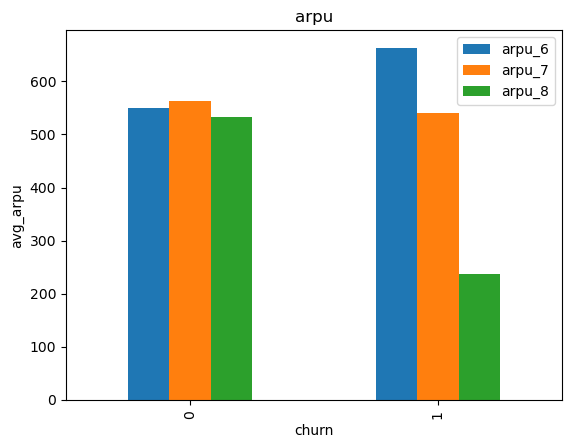

In [46]:
bar('arpu',None)

**average arpu showed a decreasing trend over the months for customers who churned**

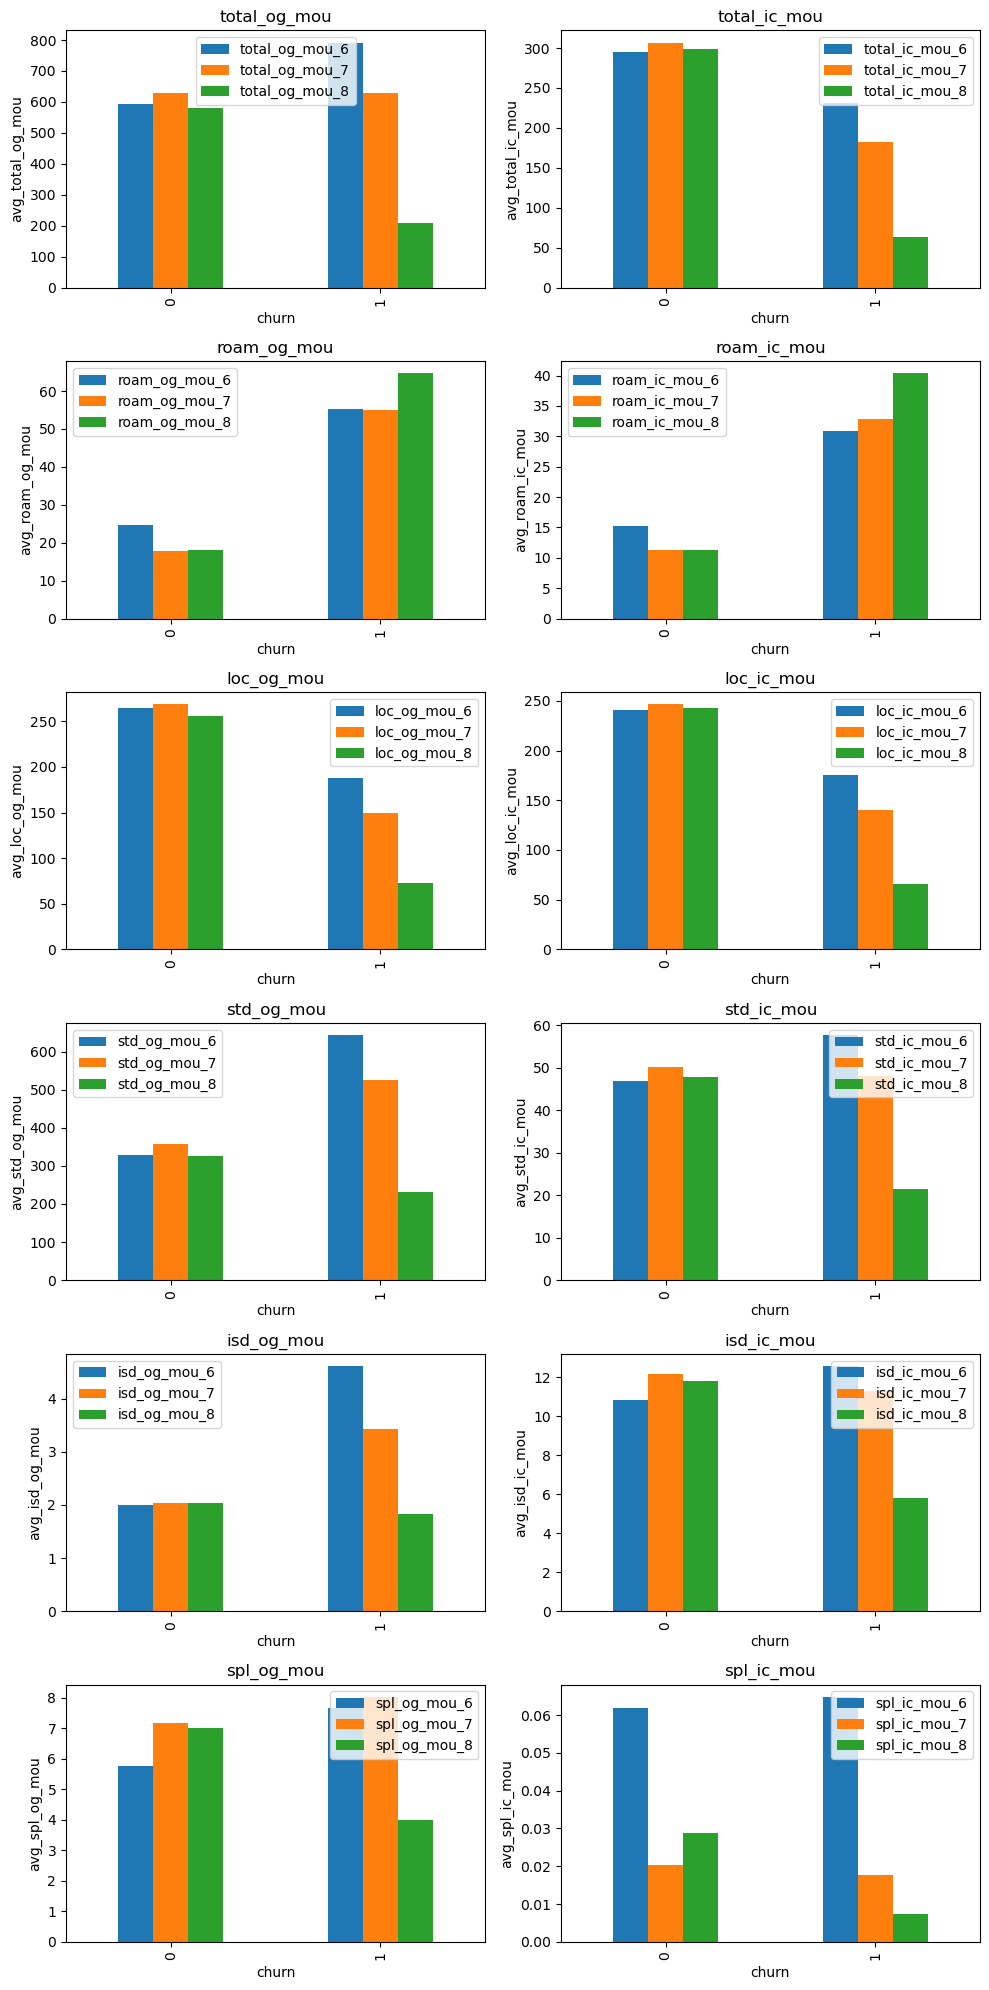

In [47]:
fig, axes = plt.subplots(6, 2, figsize=(10, 20))
axis = [[0,0],[0,1],[1,0],[1,1],[2,0],[2,1],[3,0],[3,1],[4,0],[4,1],[5,0],[5,1]]
cols = ['total_og_mou','total_ic_mou','roam_og_mou','roam_ic_mou','loc_og_mou','loc_ic_mou','std_og_mou','std_ic_mou','isd_og_mou','isd_ic_mou','spl_og_mou','spl_ic_mou']
for i,j in zip(axis,cols):
    plt.sca(axes[i[0],i[1]])
    bar(j,axes[i[0],i[1]])
plt.tight_layout()

**Insights**
* Customers who churned, showed increasing minutes of usage for roaming incoming.
* All other minutes of usage such as local, std, isd, spl reduced drastically over the previous months.
* Customers that did not churn had somewhat constant average minutes of usage.

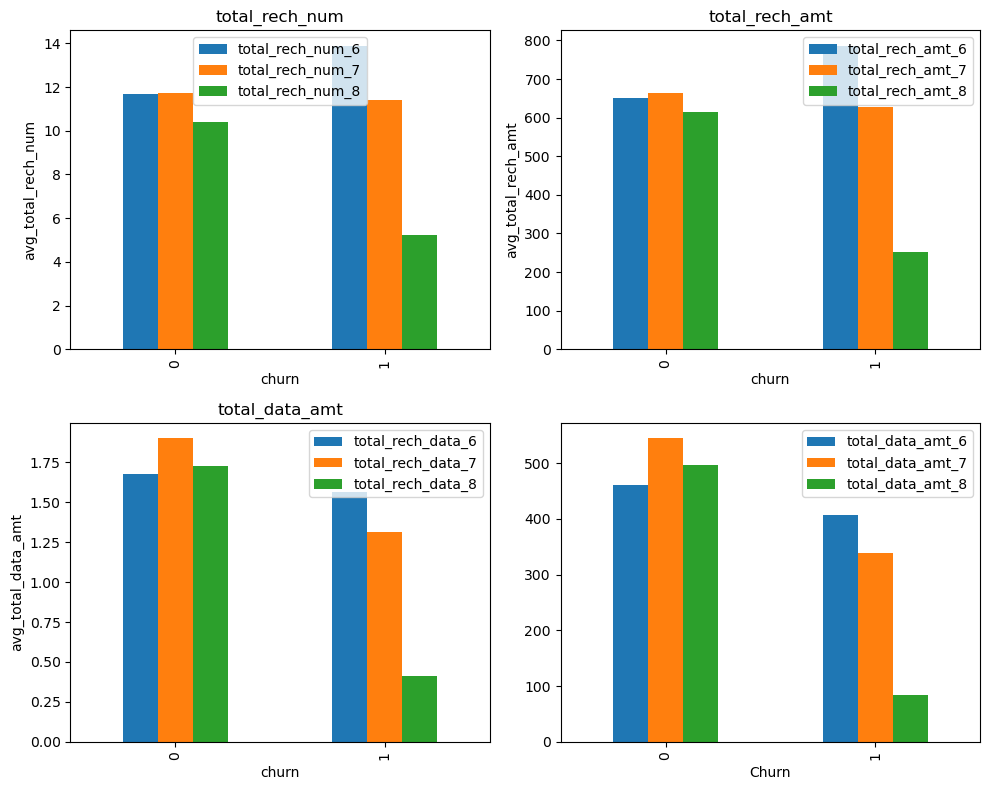

In [48]:
#Analyzing recharge variables
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
plt.sca(axes[0,0])
bar('total_rech_num',axes[0,0])
plt.sca(axes[0,1])
bar('total_rech_amt',axes[0,1])
plt.sca(axes[1,0])
bar('total_rech_data',axes[1,0])
plt.sca(axes[1,0])
bar('total_data_amt',axes[1,1])
plt.tight_layout()

**Insights**
* The average recharge amount continuously dropped over the months for churners

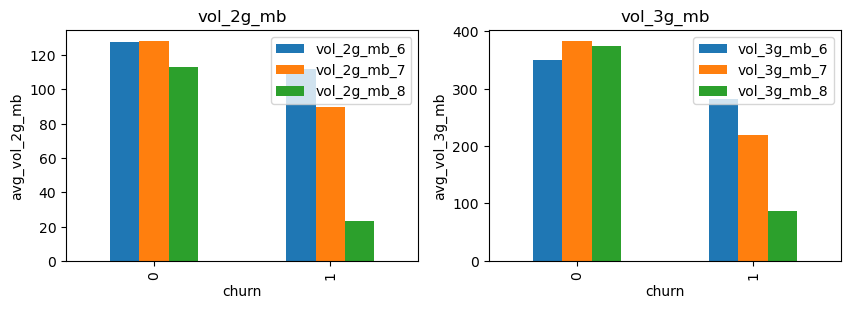

In [49]:
#Analyzing vol of data used
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
plt.sca(axes[0])
bar('vol_2g_mb',axes[0])
plt.sca(axes[1])
bar('vol_3g_mb',axes[1])

**Insights**
* The average volume of data used continuously dropped over the months for churners

Text(0, 0.5, 'Age on Network')

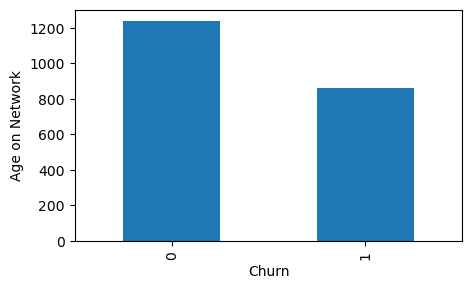

In [50]:
plt.figure(figsize=(5,3))
data.groupby('Churn')['aon'].mean().plot.bar()
plt.ylabel('Age on Network')

**Insights**
* Churners are relatively new customers with slightly fewers days on the network than non-churners

In [51]:
#Analyzing vbc columns
data.columns[data.columns.str.contains('vbc')]

Index(['aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g'], dtype='object')

In [52]:
#Converting vbc columns to desired types by replacinf month name with corresponding numbers
#Also dropping sep_vbc_3g as it corresponds to month 9
data.drop('sep_vbc_3g',axis=1,inplace=True)
data = data.rename(columns={'aug_vbc_3g':'vbc_3g_8','jul_vbc_3g':'vbc_3g_7','jun_vbc_3g':'vbc_3g_6'})

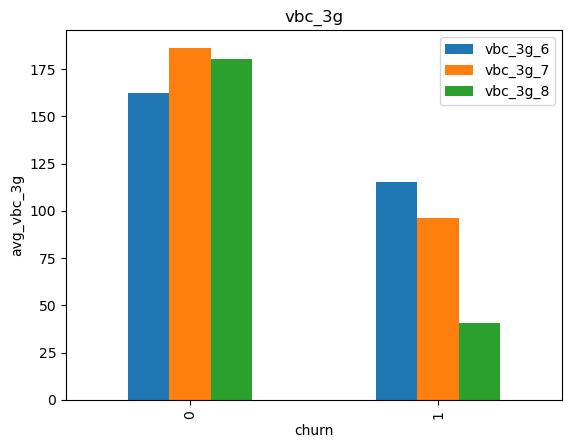

In [53]:
bar('vbc_3g',None)

* Similar decreasing trend is seen

### Deriving new features

* Lets combine 6 and 7 month columns by taking their average on each seperate feature, since this is the good phase

In [54]:
data.info('All')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30001 entries, 0 to 99997
Data columns (total 141 columns):
 #    Column               Dtype  
---   ------               -----  
 0    arpu_6               float64
 1    arpu_7               float64
 2    arpu_8               float64
 3    onnet_mou_6          float64
 4    onnet_mou_7          float64
 5    onnet_mou_8          float64
 6    offnet_mou_6         float64
 7    offnet_mou_7         float64
 8    offnet_mou_8         float64
 9    roam_ic_mou_6        float64
 10   roam_ic_mou_7        float64
 11   roam_ic_mou_8        float64
 12   roam_og_mou_6        float64
 13   roam_og_mou_7        float64
 14   roam_og_mou_8        float64
 15   loc_og_t2t_mou_6     float64
 16   loc_og_t2t_mou_7     float64
 17   loc_og_t2t_mou_8     float64
 18   loc_og_t2m_mou_6     float64
 19   loc_og_t2m_mou_7     float64
 20   loc_og_t2m_mou_8     float64
 21   loc_og_t2f_mou_6     float64
 22   loc_og_t2f_mou_7     float64
 23   loc_og_t2

In [55]:
#getting unique prefixes for each feature column and dropping uneccassary features for combining
col_prefix = [i[:-2] for i in data.columns[data.columns.str.contains('_6')]]
col_prefix

['arpu',
 'onnet_mou',
 'offnet_mou',
 'roam_ic_mou',
 'roam_og_mou',
 'loc_og_t2t_mou',
 'loc_og_t2m_mou',
 'loc_og_t2f_mou',
 'loc_og_t2c_mou',
 'loc_og_mou',
 'std_og_t2t_mou',
 'std_og_t2m_mou',
 'std_og_t2f_mou',
 'std_og_mou',
 'isd_og_mou',
 'spl_og_mou',
 'og_others',
 'total_og_mou',
 'loc_ic_t2t_mou',
 'loc_ic_t2m_mou',
 'loc_ic_t2f_mou',
 'loc_ic_mou',
 'std_ic_t2t_mou',
 'std_ic_t2m_mou',
 'std_ic_t2f_mou',
 'std_ic_mou',
 'total_ic_mou',
 'spl_ic_mou',
 'isd_ic_mou',
 'ic_others',
 'total_rech_num',
 'total_rech_amt',
 'max_rech_amt',
 'date_of_last_rech',
 'last_day_rch_amt',
 'total_rech_data',
 'max_rech_data',
 'av_rech_amt_data',
 'vol_2g_mb',
 'vol_3g_mb',
 'monthly_2g',
 'sachet_2g',
 'monthly_3g',
 'sachet_3g',
 'vbc_3g',
 'total_data_amt']

In [56]:
col_prefix.remove('date_of_last_rech')

In [57]:
#imputing missing values for the above columns with 0
for i in col_prefix:
    data[i+'_6'] = data[i+'_6'].replace(np.NaN,0)
    data[i+'_7'] = data[i+'_7'].replace(np.NaN,0)

In [58]:
#Creating columns for good phase
for i in col_prefix:
    data[i+'_gh'] = data[[i+'_6',i+'_7']].mean(axis=1)
data.shape

(30001, 186)

In [59]:
data.info('All')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30001 entries, 0 to 99997
Data columns (total 186 columns):
 #    Column               Dtype  
---   ------               -----  
 0    arpu_6               float64
 1    arpu_7               float64
 2    arpu_8               float64
 3    onnet_mou_6          float64
 4    onnet_mou_7          float64
 5    onnet_mou_8          float64
 6    offnet_mou_6         float64
 7    offnet_mou_7         float64
 8    offnet_mou_8         float64
 9    roam_ic_mou_6        float64
 10   roam_ic_mou_7        float64
 11   roam_ic_mou_8        float64
 12   roam_og_mou_6        float64
 13   roam_og_mou_7        float64
 14   roam_og_mou_8        float64
 15   loc_og_t2t_mou_6     float64
 16   loc_og_t2t_mou_7     float64
 17   loc_og_t2t_mou_8     float64
 18   loc_og_t2m_mou_6     float64
 19   loc_og_t2m_mou_7     float64
 20   loc_og_t2m_mou_8     float64
 21   loc_og_t2f_mou_6     float64
 22   loc_og_t2f_mou_7     float64
 23   loc_og_t2

In [60]:
#Now lets remove all _6 and _7 columns from col_prefix
for i in col_prefix:
    data.drop([i+'_6',i+'_7'],axis=1,inplace=True)
data.shape

(30001, 96)

In [61]:
#Lets further drop any data columns
data.drop(data.columns[data.columns.str.contains('date')],axis=1,inplace=True)
data.shape

(30001, 93)

In [62]:
data.info('All')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30001 entries, 0 to 99997
Data columns (total 93 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   arpu_8               30001 non-null  float64
 1   onnet_mou_8          28827 non-null  float64
 2   offnet_mou_8         28827 non-null  float64
 3   roam_ic_mou_8        28827 non-null  float64
 4   roam_og_mou_8        28827 non-null  float64
 5   loc_og_t2t_mou_8     28827 non-null  float64
 6   loc_og_t2m_mou_8     28827 non-null  float64
 7   loc_og_t2f_mou_8     28827 non-null  float64
 8   loc_og_t2c_mou_8     28827 non-null  float64
 9   loc_og_mou_8         28827 non-null  float64
 10  std_og_t2t_mou_8     28827 non-null  float64
 11  std_og_t2m_mou_8     28827 non-null  float64
 12  std_og_t2f_mou_8     28827 non-null  float64
 13  std_og_mou_8         28827 non-null  float64
 14  isd_og_mou_8         28827 non-null  float64
 15  spl_og_mou_8         28827 non-null 

In [63]:
#Lets check null values again
null_perc = nulls(data)
null_perc[null_perc > 0].sort_values(ascending=True)

onnet_mou_8         3.913203
spl_ic_mou_8        3.913203
std_ic_mou_8        3.913203
std_ic_t2f_mou_8    3.913203
std_ic_t2m_mou_8    3.913203
std_ic_t2t_mou_8    3.913203
loc_ic_mou_8        3.913203
loc_ic_t2f_mou_8    3.913203
loc_ic_t2m_mou_8    3.913203
loc_ic_t2t_mou_8    3.913203
og_others_8         3.913203
spl_og_mou_8        3.913203
isd_ic_mou_8        3.913203
isd_og_mou_8        3.913203
std_og_t2f_mou_8    3.913203
std_og_t2m_mou_8    3.913203
std_og_t2t_mou_8    3.913203
loc_og_mou_8        3.913203
loc_og_t2c_mou_8    3.913203
loc_og_t2f_mou_8    3.913203
loc_og_t2m_mou_8    3.913203
loc_og_t2t_mou_8    3.913203
roam_og_mou_8       3.913203
roam_ic_mou_8       3.913203
offnet_mou_8        3.913203
std_og_mou_8        3.913203
ic_others_8         3.913203
dtype: float64

In [64]:
#Lets replace null values with 0
for i in null_perc[null_perc > 0].index:
    data[i] = data[i].replace(np.NaN,0)
data.isnull().sum().sum()

0

**All the missing values have been handled**

#### Handling Outliers

In [65]:
pd.set_option('display.max_columns',None)
quantiles = [0.25,0.5,0.75,0.9,0.95]
data.describe(percentiles=quantiles)

arpu_8   onnet_mou_8  offnet_mou_8  roam_ic_mou_8  roam_og_mou_8  \
count  30001.000000  30001.000000  30001.000000   30001.000000   30001.000000   
mean     508.597957    234.112539    335.077044      12.500551      19.865615   
std      501.961981    458.448598    482.062509      74.125281     104.719009   
min     -945.808000      0.000000      0.000000       0.000000       0.000000   
25%      231.473000     10.390000     46.740000       0.000000       0.000000   
50%      427.585000     65.610000    182.790000       0.000000       0.000000   
75%      661.491000    239.960000    438.890000       0.000000       0.000000   
90%      977.345000    665.080000    823.680000      15.010000      28.880000   
95%     1255.019000   1074.590000   1167.540000      56.350000     100.510000   
max    33543.624000  10752.560000  14007.340000    4169.810000    5337.040000   

       loc_og_t2t_mou_8  loc_og_t2m_mou_8  loc_og_t2f_mou_8  loc_og_t2c_mou_8  \
count      30001.000000      30001.000000      30001.000000      30001.000000   
mean          78.077112        151.756812          5.886385          1.707746   
std          227.373609        233.660905         19.502281          7.208138   
min            0.000000          0.000000          0.000000          0.000000   
25%            2.530000         13.090000          0.000000          0.000000   
50%           20.730000         67.760000          0.000000          0.000000   
75%           72.040000        196.960000          3.930000          0.010000   
90%          178.840000        398.510000         15.160000          4.580000   
95%          298.780000        574.760000         28.390000          9.380000   
max        10752.560000       4961.330000        928.490000        351.830000   

       loc_og_mou_8  std_og_t2t_mou_8  std_og_t2m_mou_8  std_og_t2f_mou_8  \
count  30001.000000      30001.000000      30001.000000      30001.000000   
mean     235.728174        148.441175        157.350068          1.584734   
std      363.370172        397.564547        409.100284         10.931804   
min        0.000000          0.000000          0.000000          0.000000   
25%       22.460000          0.000000          0.000000          0.000000   
50%      110.810000          0.630000          9.460000          0.000000   
75%      310.610000         78.190000        117.780000          0.000000   
90%      607.830000        475.360000        464.890000          1.280000   
95%      859.780000        887.460000        842.830000          5.930000   
max    11039.910000       8014.430000      13950.040000        516.910000   

       std_og_mou_8  isd_og_mou_8  spl_og_mou_8   og_others_8  total_og_mou_8  \
count  30001.000000  30001.000000  30001.000000  30001.000000    30001.000000   
mean     307.379315      1.948970      6.557204      0.057607      551.678812   
std      608.976504     44.712024     20.311857      3.315125      700.478180   
min        0.000000      0.000000      0.000000      0.000000        0.000000   
25%        0.000000      0.000000      0.000000      0.000000       72.360000   
50%       25.480000      0.000000      0.430000      0.000000      333.540000   
75%      357.230000      0.000000      6.150000      0.000000      774.780000   
90%     1002.860000      0.000000     17.610000      0.000000     1359.590000   
95%     1476.160000      0.360000     29.280000      0.000000     1857.080000   
max    13980.060000   5681.540000    954.510000    394.930000    14043.060000   

       loc_ic_t2t_mou_8  loc_ic_t2m_mou_8  loc_ic_t2f_mou_8  loc_ic_mou_8  \
count      30001.000000      30001.000000      30001.000000  30001.000000   
mean          62.619432        146.232731         14.403175    223.264679   
std          158.912293        214.882624         43.305191    308.315153   
min            0.000000          0.000000          0.000000      0.000000   
25%            4.880000         24.210000          0.000000     40.530000   
50%           22.610000    

* Almost all columns have outliers
* Lets cap all columns to 95th quantile

In [66]:
for i in data.columns:
    data[i] = data[i].clip(upper=data[i].quantile(0.95))
data.describe(percentiles=quantiles)

arpu_8   onnet_mou_8  offnet_mou_8  roam_ic_mou_8  roam_og_mou_8  \
count  30001.000000  30001.000000  30001.000000   30001.000000   30001.000000   
mean     480.242521    198.648585    300.470944       4.791270       8.695463   
std      331.409634    293.823756    327.420614      13.895008      25.057610   
min     -945.808000      0.000000      0.000000       0.000000       0.000000   
25%      231.473000     10.390000     46.740000       0.000000       0.000000   
50%      427.585000     65.610000    182.790000       0.000000       0.000000   
75%      661.491000    239.960000    438.890000       0.000000       0.000000   
90%      977.345000    665.080000    823.680000      15.010000      28.880000   
95%     1255.019000   1074.590000   1167.540000      56.350000     100.510000   
max     1255.019000   1074.590000   1167.540000      56.350000     100.510000   

       loc_og_t2t_mou_8  loc_og_t2m_mou_8  loc_og_t2f_mou_8  loc_og_t2c_mou_8  \
count      30001.000000      30001.000000      30001.000000      30001.000000   
mean          56.490501        135.122899          4.024482          1.048060   
std           80.731190        162.619799          7.637428          2.500788   
min            0.000000          0.000000          0.000000          0.000000   
25%            2.530000         13.090000          0.000000          0.000000   
50%           20.730000         67.760000          0.000000          0.000000   
75%           72.040000        196.960000          3.930000          0.010000   
90%          178.840000        398.510000         15.160000          4.580000   
95%          298.780000        574.760000         28.390000          9.380000   
max          298.780000        574.760000         28.390000          9.380000   

       loc_og_mou_8  std_og_t2t_mou_8  std_og_t2m_mou_8  std_og_t2f_mou_8  \
count  30001.000000      30001.000000      30001.000000      30001.000000   
mean     209.462733        115.716316        122.809826          0.473680   
std      244.926221        240.022338        228.110409          1.449762   
min        0.000000          0.000000          0.000000          0.000000   
25%       22.460000          0.000000          0.000000          0.000000   
50%      110.810000          0.630000          9.460000          0.000000   
75%      310.610000         78.190000        117.780000          0.000000   
90%      607.830000        475.360000        464.890000          1.280000   
95%      859.780000        887.460000        842.830000          5.930000   
max      859.780000        887.460000        842.830000          5.930000   

       std_og_mou_8  isd_og_mou_8  spl_og_mou_8  og_others_8  total_og_mou_8  \
count  30001.000000  30001.000000  30001.000000      30001.0    30001.000000   
mean     265.637532      0.020268      4.868652          0.0      508.731528   
std      429.853560      0.081298      8.135537          0.0      531.424913   
min        0.000000      0.000000      0.000000          0.0        0.000000   
25%        0.000000      0.000000      0.000000          0.0       72.360000   
50%       25.480000      0.000000      0.430000          0.0      333.540000   
75%      357.230000      0.000000      6.150000          0.0      774.780000   
90%     1002.860000      0.000000     17.610000          0.0     1359.590000   
95%     1476.160000      0.360000     29.280000          0.0     1857.080000   
max     1476.160000      0.360000     29.280000          0.0     1857.080000   

       loc_ic_t2t_mou_8  loc_ic_t2m_mou_8  loc_ic_t2f_mou_8  loc_ic_mou_8  \
count      30001.000000      30001.000000      30001.000000  30001.000000   
mean          47.846860        130.082933         10.247960    200.686463   
std           60.981573        140.453224         17.646403    210.163531   
min            0.000000          0.000000          0.000000      0.000000   
25%            4.880000         24.210000          0.000000     40.530000   
50%           22.610000         80.040

In [67]:
data.shape

(30001, 93)

In [68]:
data.info('All')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30001 entries, 0 to 99997
Data columns (total 93 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   arpu_8               30001 non-null  float64
 1   onnet_mou_8          30001 non-null  float64
 2   offnet_mou_8         30001 non-null  float64
 3   roam_ic_mou_8        30001 non-null  float64
 4   roam_og_mou_8        30001 non-null  float64
 5   loc_og_t2t_mou_8     30001 non-null  float64
 6   loc_og_t2m_mou_8     30001 non-null  float64
 7   loc_og_t2f_mou_8     30001 non-null  float64
 8   loc_og_t2c_mou_8     30001 non-null  float64
 9   loc_og_mou_8         30001 non-null  float64
 10  std_og_t2t_mou_8     30001 non-null  float64
 11  std_og_t2m_mou_8     30001 non-null  float64
 12  std_og_t2f_mou_8     30001 non-null  float64
 13  std_og_mou_8         30001 non-null  float64
 14  isd_og_mou_8         30001 non-null  float64
 15  spl_og_mou_8         30001 non-null 

**Checking multicollinearity**

<Axes: >

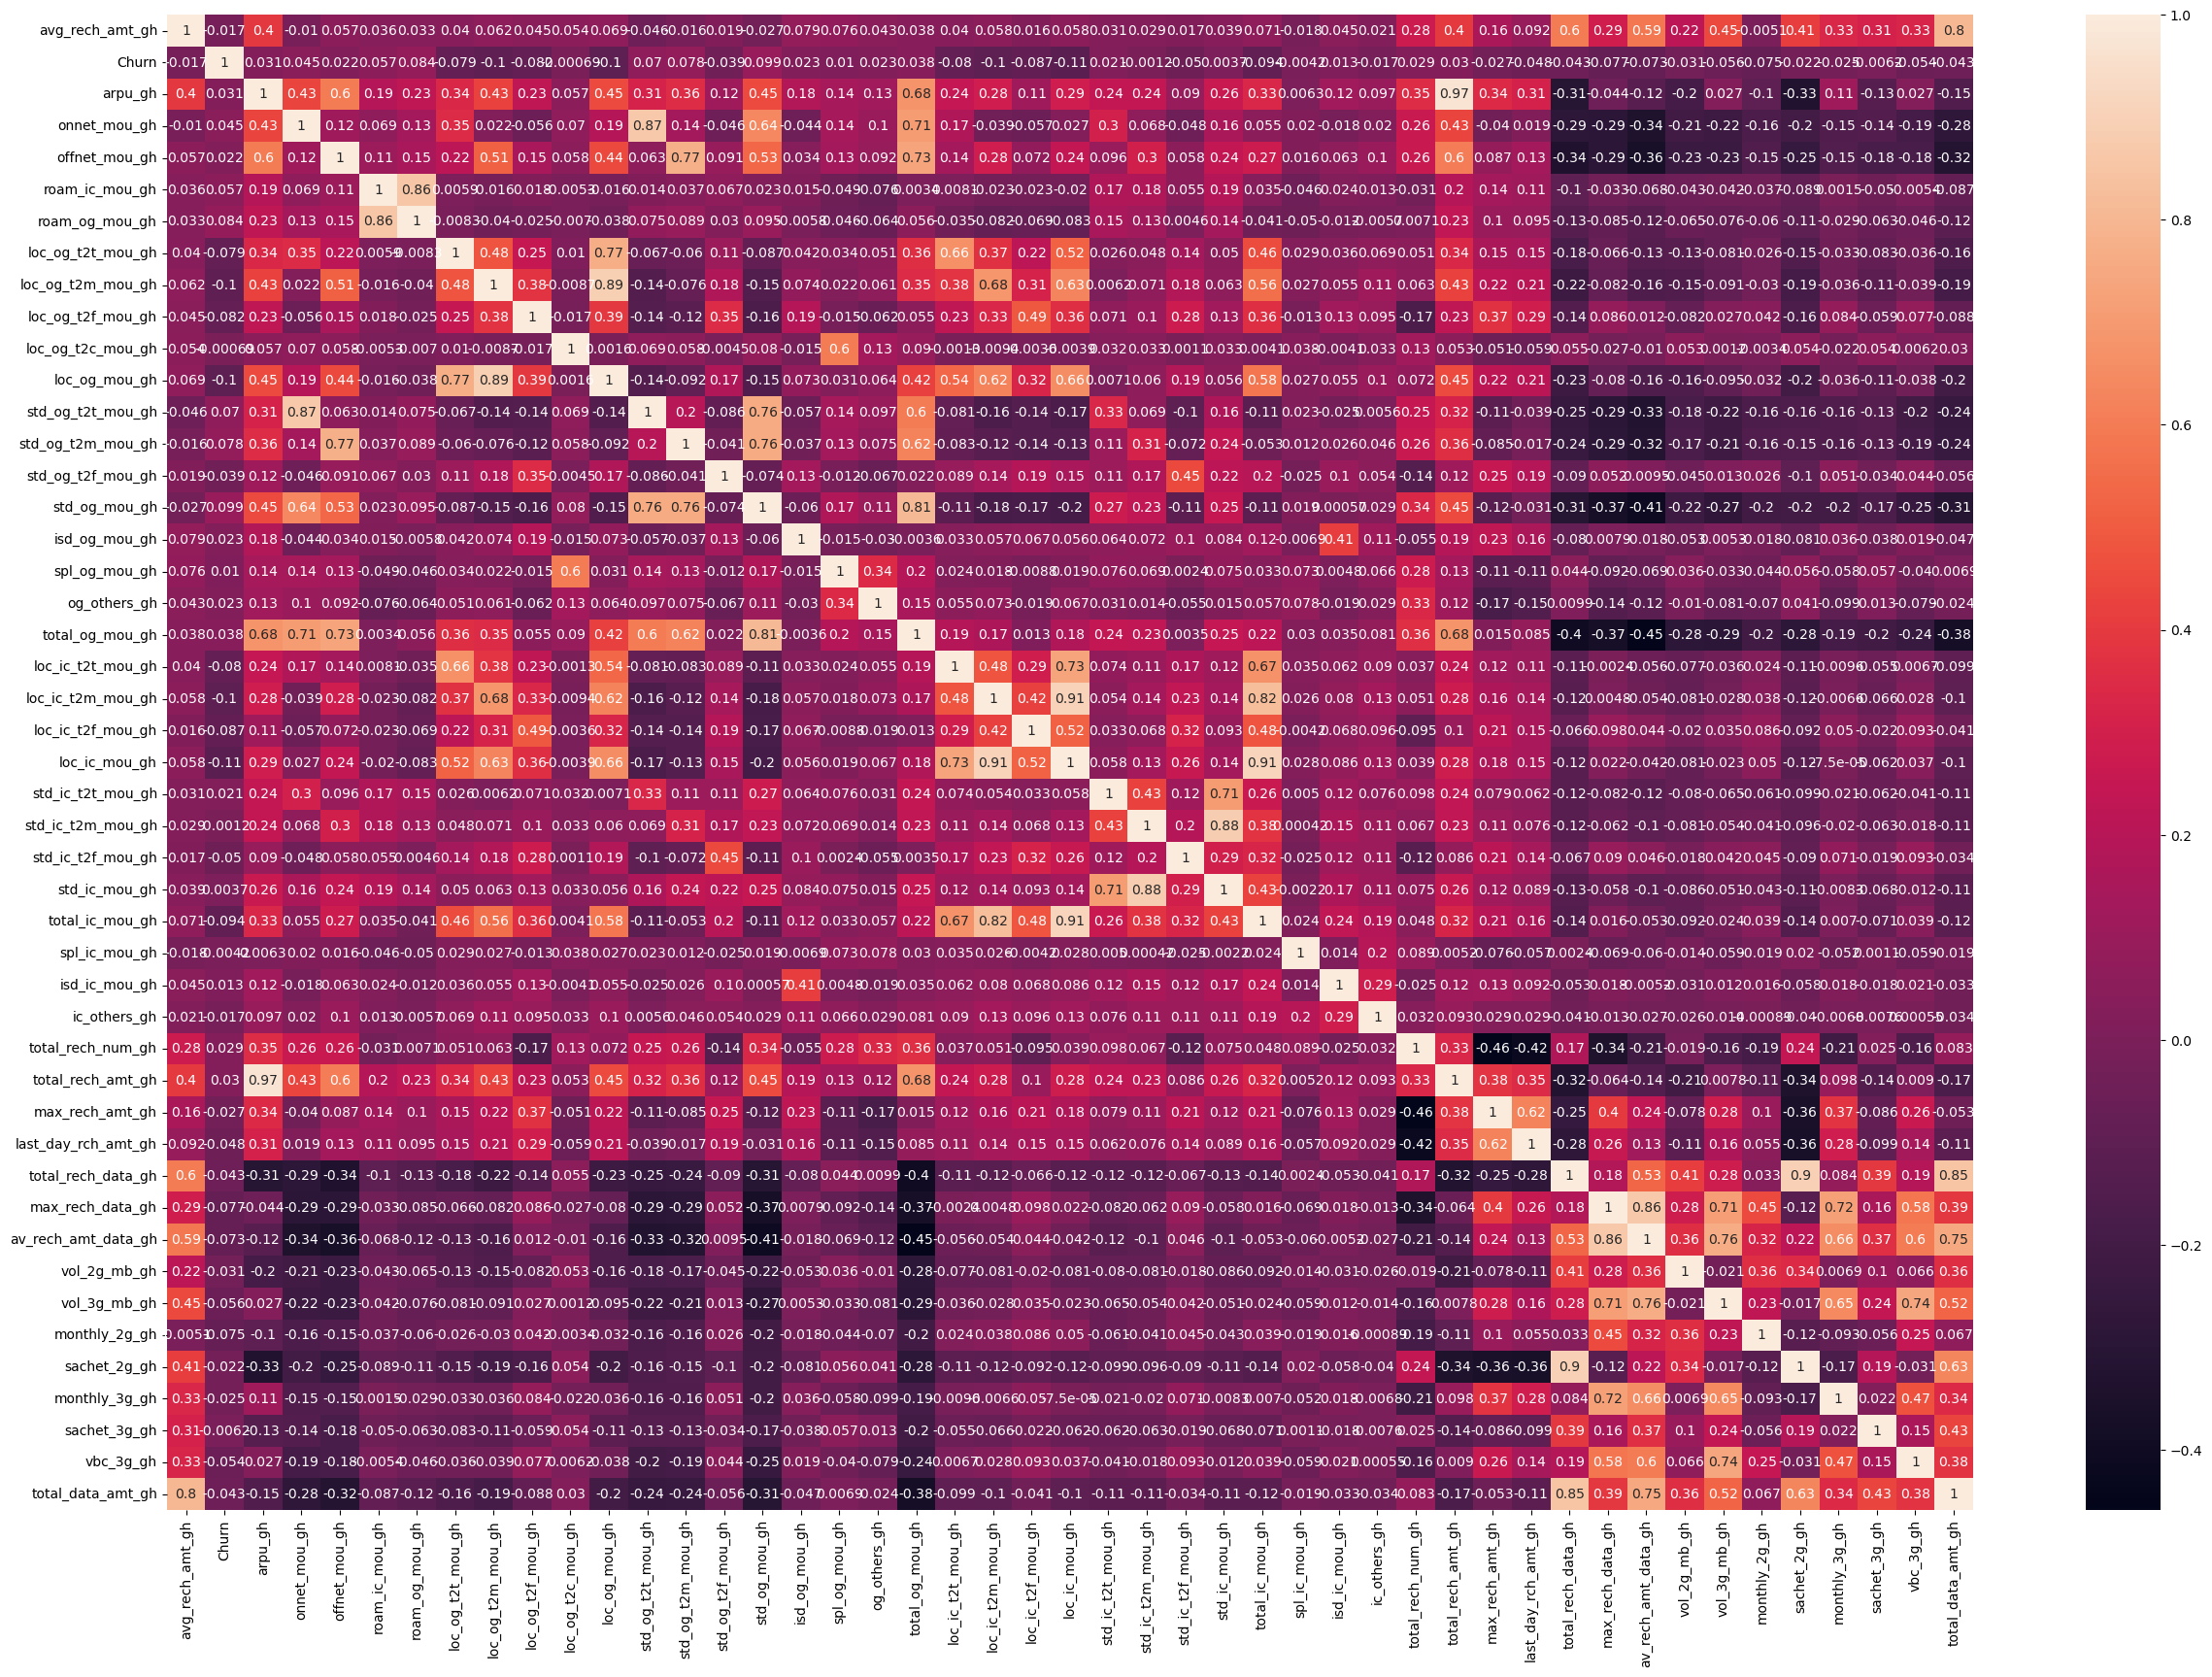

In [69]:
#Checking correlations in good phase
data_gh = data[data.columns[ (data.columns.str.contains('_gh')) | (data.columns.str.contains('Churn'))] ]
cont_corr_coef = data_gh.corr()
plt.figure(figsize=(30,20))
sns.heatmap(cont_corr_coef,cbar=True, annot=True)

In [70]:
top_corr = cont_corr_coef.unstack().sort_values(ascending=False)
top_corr = top_corr[top_corr != 1]
top_corr[:20:2]

total_rech_amt_gh   arpu_gh                0.969797
loc_ic_mou_gh       total_ic_mou_gh        0.911989
loc_ic_t2m_mou_gh   loc_ic_mou_gh          0.905263
sachet_2g_gh        total_rech_data_gh     0.897335
loc_og_t2m_mou_gh   loc_og_mou_gh          0.891005
std_ic_mou_gh       std_ic_t2m_mou_gh      0.882470
std_og_t2t_mou_gh   onnet_mou_gh           0.867658
max_rech_data_gh    av_rech_amt_data_gh    0.863652
roam_og_mou_gh      roam_ic_mou_gh         0.856575
total_rech_data_gh  total_data_amt_gh      0.847879
dtype: float64

In [71]:
corr_cols = ['total_rech_amt_gh','loc_ic_mou_gh','loc_ic_t2m_mou_gh','sachet_2g_gh','loc_og_t2m_mou_gh','std_ic_mou_gh','std_og_t2t_mou_gh','max_rech_data_gh','roam_og_mou_gh','total_rech_data_gh']
data_final = data.drop(corr_cols,axis=1)
data_final.shape

(30001, 83)

<Axes: >

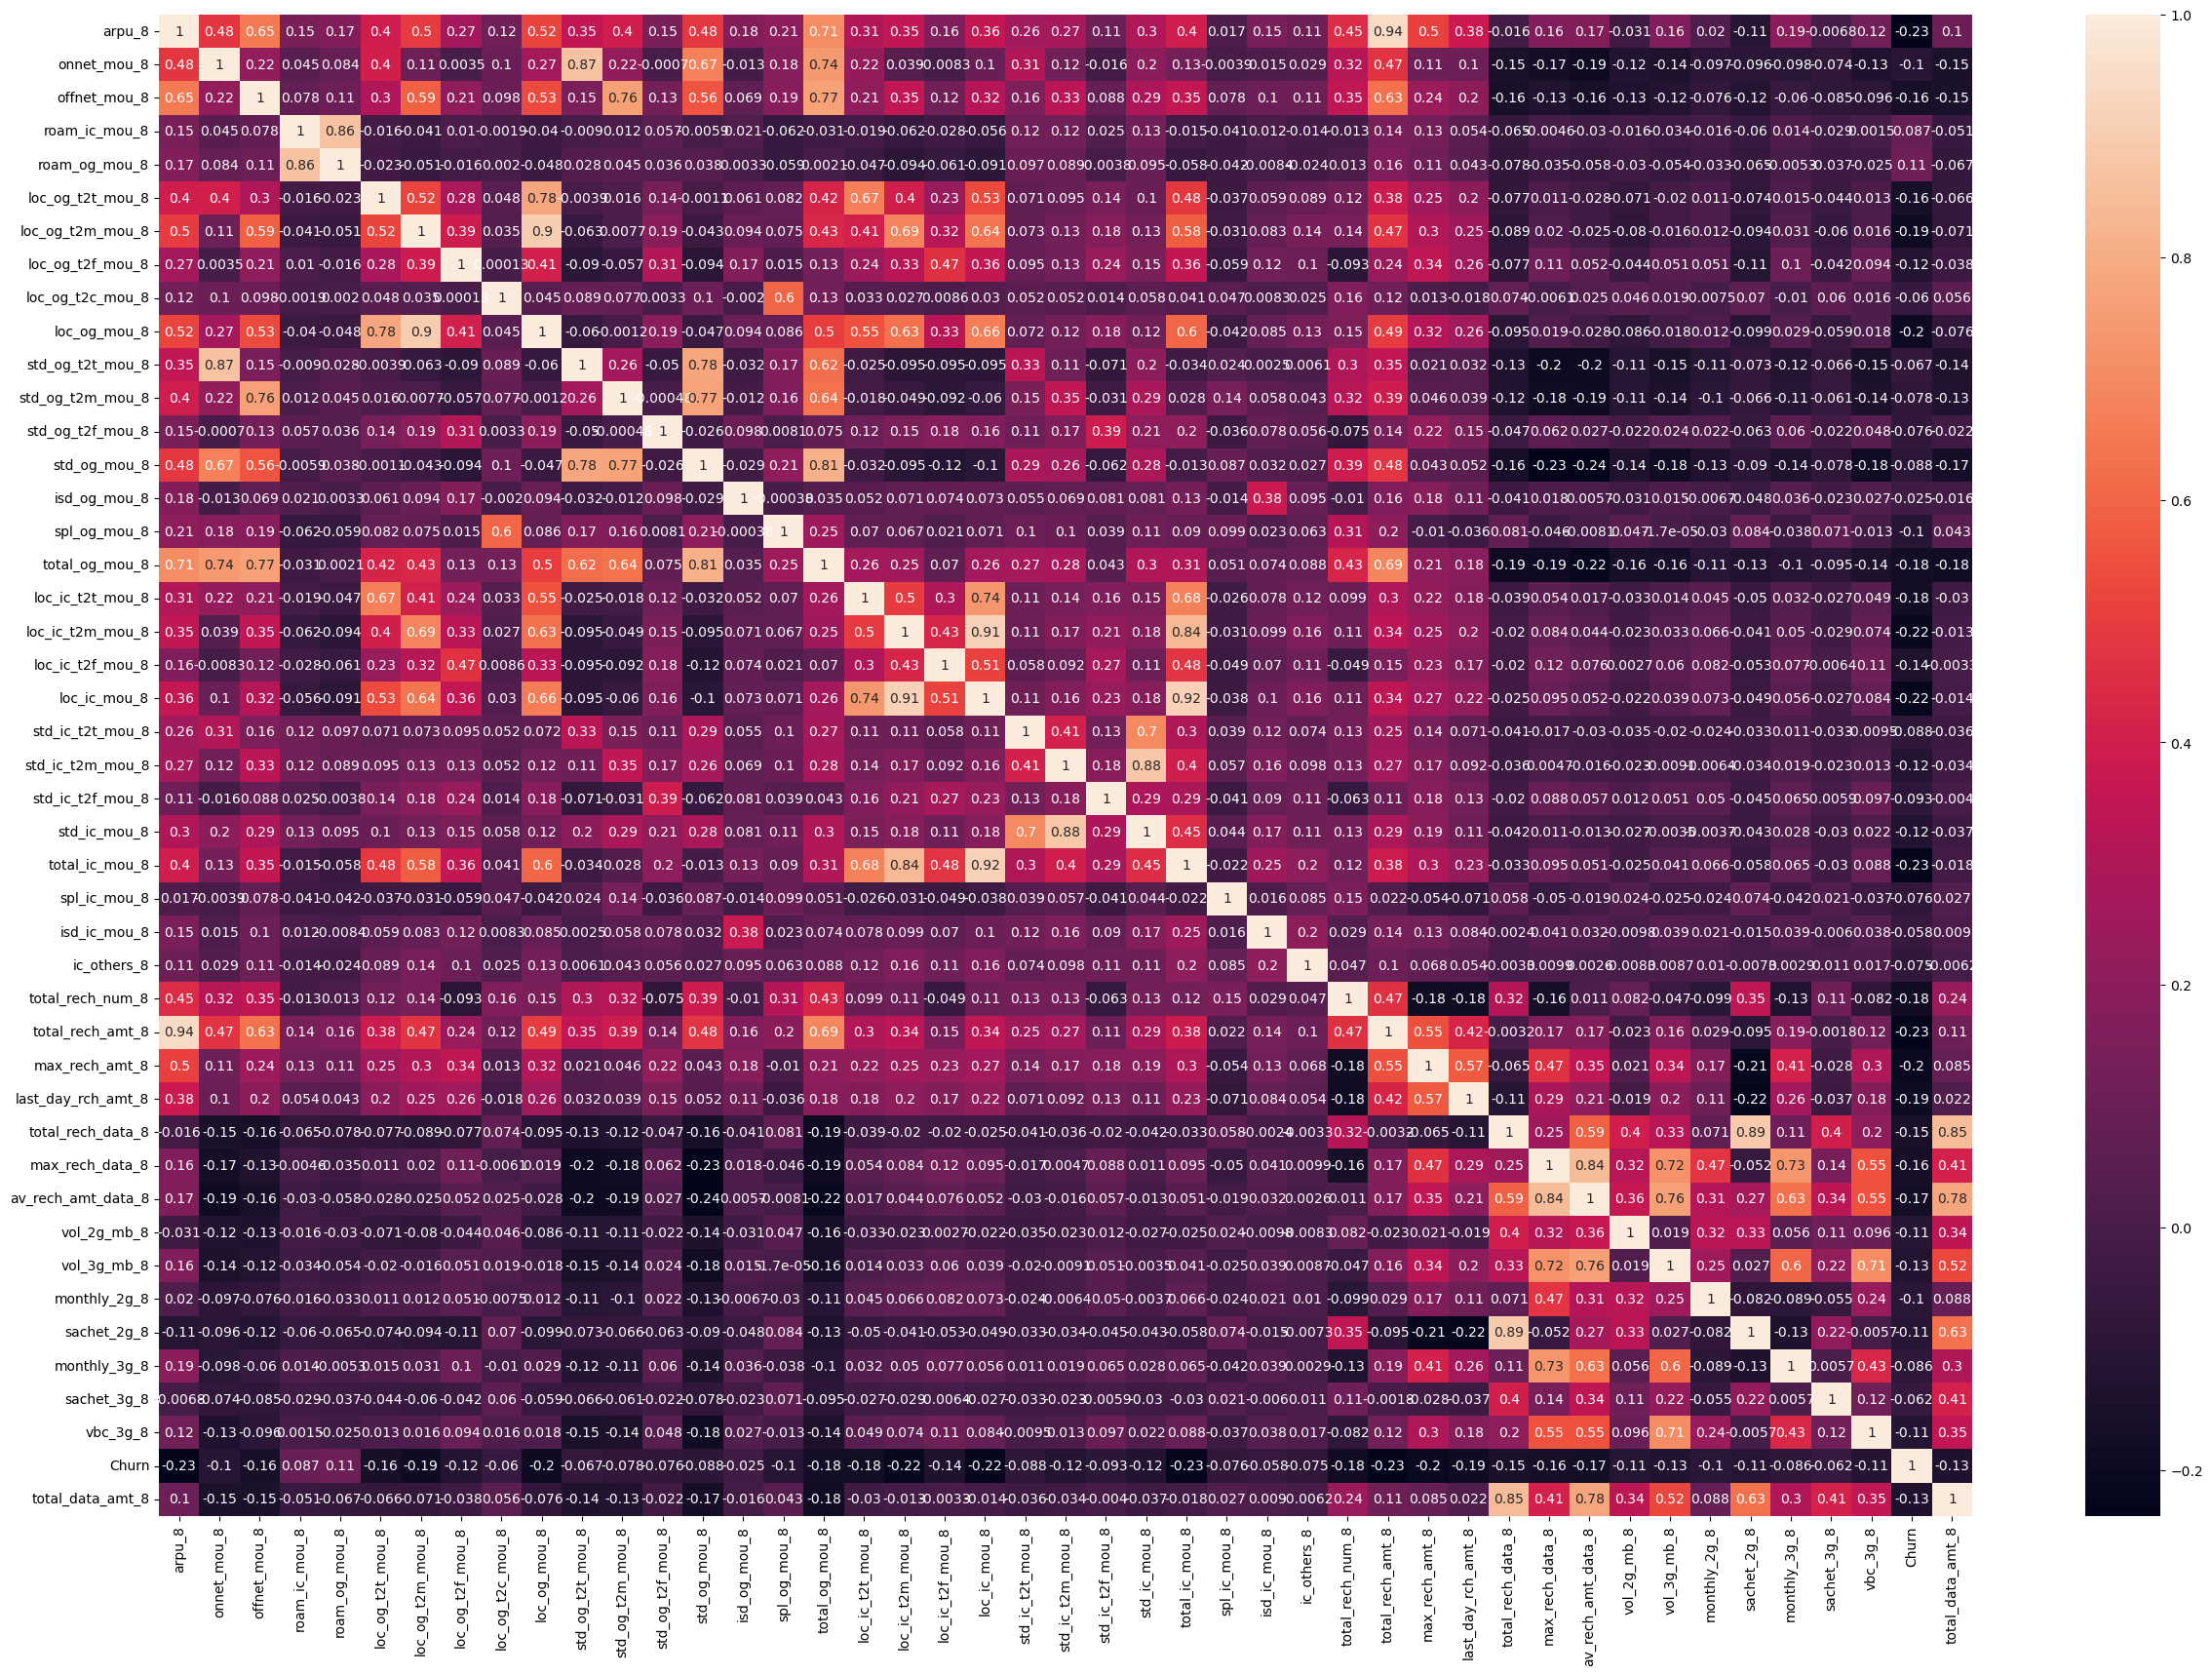

In [72]:
#Checking correlations in action phase
data.drop('og_others_8',axis=1,inplace=True)
data_gh = data[data.columns[ (data.columns.str.contains('_8')) | (data.columns.str.contains('Churn'))] ]
cont_corr_coef = data_gh.corr()
plt.figure(figsize=(30,20))
sns.heatmap(cont_corr_coef,cbar=True, annot=True)

In [75]:
#Finding highly correlated variables
top_corr = cont_corr_coef.unstack().sort_values(ascending=False)
top_corr = top_corr[top_corr != 1]
top_corr[:20:2]

total_rech_amt_8    arpu_8               0.943556
loc_ic_mou_8        total_ic_mou_8       0.915969
loc_ic_t2m_mou_8    loc_ic_mou_8         0.914521
loc_og_mou_8        loc_og_t2m_mou_8     0.902802
total_rech_data_8   sachet_2g_8          0.892751
std_ic_t2m_mou_8    std_ic_mou_8         0.882541
onnet_mou_8         std_og_t2t_mou_8     0.865459
roam_ic_mou_8       roam_og_mou_8        0.864806
total_data_amt_8    total_rech_data_8    0.847668
av_rech_amt_data_8  max_rech_data_8      0.844836
dtype: float64

In [73]:
corr_cols = ['total_rech_amt_8','loc_ic_mou_8','loc_ic_t2m_mou_8','loc_og_mou_8','total_rech_data_8','std_ic_t2m_mou_8','onnet_mou_8','roam_ic_mou_8','total_data_amt_8','av_rech_amt_data_8']
data_final = data_final.drop(corr_cols,axis=1)
data_final.shape

(30001, 73)

In [74]:
cont_corr_coef = data_final.corr()
top_corr = cont_corr_coef.unstack().sort_values(ascending=False)
top_corr = top_corr[top_corr != 1]
top_corr[:20:2]

loc_og_t2t_mou_8  loc_og_t2t_mou_gh    0.821568
total_ic_mou_gh   total_ic_mou_8       0.819365
std_og_mou_8      total_og_mou_8       0.813686
std_og_mou_gh     total_og_mou_gh      0.807687
avg_rech_amt_gh   total_data_amt_gh    0.804963
loc_ic_t2t_mou_8  loc_ic_t2t_mou_gh    0.804119
loc_ic_t2f_mou_8  loc_ic_t2f_mou_gh    0.790167
std_og_mou_8      std_og_mou_gh        0.783356
                  std_og_t2t_mou_8     0.779725
std_og_t2m_mou_8  std_og_t2m_mou_gh    0.779474
dtype: float64

## Model Building

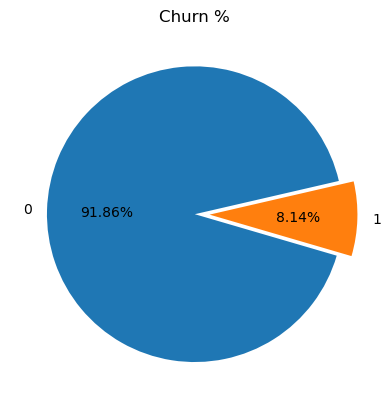

In [203]:
#Lets analyze the target column
plt.pie(data_final.Churn.value_counts(normalize=True),autopct='%.2f%%',labels=[0,1],startangle=13,explode=(0,0.1),)
plt.title('Churn %')
plt.show()

**The data has high imbalance, lets follow the following methods for balancing the dataset**
* Lets create multiple copies of resampled datasets using various techniques:
    1. Random Undersampling
    2. SMOTE

# Train-Test split

In [88]:
from sklearn.model_selection import train_test_split
df_train,df_test = train_test_split(data_final,train_size=0.7,random_state=42,stratify=data_final['Churn'])

**Feature Scaling**

In [89]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
num_cols = df_train.drop('Churn',axis=1).columns
df_train[num_cols] = sc.fit_transform(df_train[num_cols])
df_test[num_cols] = sc.transform(df_test[num_cols])

In [90]:
y_train = df_train.pop('Churn')
X_train = df_train

In [91]:
y_train.head()

85078    0
86943    0
97445    0
71343    0
22100    0
Name: Churn, dtype: int64

In [92]:
X_train.head()

arpu_8  offnet_mou_8  roam_og_mou_8  loc_og_t2t_mou_8  \
85078  0.212084     -0.473292      -0.344615         -0.146965   
86943  0.668369     -0.550549      -0.344615          1.319293   
97445 -1.287576     -0.795068      -0.344615         -0.698472   
71343 -1.057849     -0.920141      -0.344615         -0.698472   
22100 -1.045198     -0.798676       1.465511         -0.698472   

       loc_og_t2m_mou_8  loc_og_t2f_mou_8  loc_og_t2c_mou_8  std_og_t2t_mou_8  \
85078         -0.178175         -0.527478         -0.417956          1.588922   
86943         -0.209483         -0.352901         -0.417956         -0.482562   
97445         -0.782594         -0.527478          0.638692         -0.482562   
71343         -0.830169         -0.527478         -0.417956         -0.482562   
22100         -0.830169         -0.527478          3.322179         -0.482562   

       std_og_t2m_mou_8  std_og_t2f_mou_8  std_og_mou_8  isd_og_mou_8  \
85078         -0.365867         -0.328952      0.629394     -0.249602   
86943         -0.541009          3.744539     -0.584483     -0.249602   
97445         -0.541009         -0.328952     -0.618443     -0.249602   
71343         -0.541009         -0.328952     -0.618443     -0.249602   
22100         -0.541009         -0.328952     -0.618443     -0.249602   

       spl_og_mou_8  og_others_8  total_og_mou_8  loc_ic_t2t_mou_8  \
85078      2.958939          0.0        0.406870          0.301601   
86943      0.073694          0.0       -0.420369          2.894973   
97445      2.958939          0.0       -0.873287         -0.761023   
71343     -0.598113          0.0       -0.955712         -0.549088   
22100     -0.598113          0.0       -0.955712         -0.782003   

       loc_ic_t2f_mou_8  std_ic_t2t_mou_8  std_ic_t2f_mou_8  std_ic_mou_8  \
85078         -0.582639          3.244216         -0.392224      2.269439   
86943         -0.170257         -0.513420         -0.392224     -0.647144   
97445         -0.582639         -0.513420         -0.392224     -0.647144   
71343         -0.568379         -0.513420         -0.392224     -0.647144   
22100         -0.582639         -0.513420         -0.392224     -0.647144   

       total_ic_mou_8  spl_ic_mou_8  isd_ic_mou_8  ic_others_8  \
85078        0.420764     -0.289992     -0.360585    -0.377899   
86943        0.992864     -0.289992     -0.360585    -0.345594   
97445       -0.924574     -0.289992     -0.360585    -0.377899   
71343       -0.892586     -0.289992     -0.360585    -0.377899   
22100       -1.006450     -0.289992     -0.360585    -0.377899   

       total_rech_num_8  max_rech_amt_8  last_day_rch_amt_8  max_rech_data_8  \
85078          2.447351       -0.158338           -0.851095        -0.747546   
86943         -0.335062        0.045693            0.420370         0.948833   
97445         -0.474183       -1.132120           -0.973351        -0.468536   
71343         -1.169786        0.045693            0.884943         0.948833   
22100         -0.613303       -1.085749           -0.606582        -0.747546   

       vol_2g_mb_8  vol_3g_mb_8  monthly_2g_8  sachet_2g_8  monthly_3g_8  \
85078    -0.475315    -0.547379     -0.401956    -0.498149     -0.412762   
86943    -0.090334     1.148054     -0.401956     0.657585     -0.412762   
97445     0.446014    -0.547379     -0.401956     1.813320     -0.412762   
71343    -0.439571     0.094673     -0.401956     0.079718     -0.412762   
22100    -0.475315    -0.547379     -0.401956    -0.498149     -0.412762   

       sachet_3g_8       aon  vbc_3g_8  avg_rech_amt_gh   arpu_gh  \
85078    -0.312470 -0.158063 -0.511149        -0.510246  0.290792   
86943     3.200308 -0.878299  1.379080        -0.271191 -0.166284   
97445    -0.312470  0.432706 -0.511149        -0.807450 -1.477264   
71343     3.200308  2.119061 -0.147398        -0.424638 -1.422748   
22100    -0.312470  1.176878 -0.511149        -0.733957 -0.152358   

       onnet_mou_gh  offnet_mou_gh  roam_ic_mou_gh  

In [93]:
y_test = df_test.pop('Churn')
X_test = df_test

**Building simple logistic regression on original dataset**

In [94]:
#Lets build a simple logistic regression model
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression(random_state=42)
lg.fit(X_train,y_train)

LogisticRegression(random_state=42)

In [95]:
y_train_pred = lg.predict(X_train)

In [96]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,recall_score
print('acc: ',accuracy_score(y_train,y_train_pred))
print('recall: ',recall_score(y_train,y_train_pred))

acc:  0.9336666666666666
recall:  0.35225277940315974


In [97]:
confusion_matrix(y_train,y_train_pred)

array([[19005,   286],
       [ 1107,   602]], dtype=int64)

In [98]:
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     19291
           1       0.68      0.35      0.46      1709

    accuracy                           0.93     21000
   macro avg       0.81      0.67      0.71     21000
weighted avg       0.92      0.93      0.92     21000



* It is seen that even though the accuracy is high the recall is very low
* The focus of the model should be on recall since the percentage of correctly predicted churned customer should be maximised

### Using Resampling techniques
1. UnderSampling
2. SMOTE

**UnderSampling**

In [99]:
from imblearn.under_sampling import RandomUnderSampler
us = RandomUnderSampler(random_state=5)
X_train_us, y_train_us = us.fit_resample(X_train,y_train)
X_train_us.shape

(3418, 72)

**SMOTE**

In [100]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=45,k_neighbors=5)
X_train_smote,y_train_smote = smote.fit_resample(X_train,y_train)
X_train_smote.shape

(38582, 72)

## Dimensionality reduction using PCA

In [101]:
#Lets define functions for PCA and finding optimum number of components using scree plot
from sklearn.decomposition import PCA
def pca_scree(X,h):
    pca = PCA(random_state=42)
    pca.fit(X)
    var_cumu = np.cumsum(pca.explained_variance_ratio_)
    fig = plt.figure(figsize=[6,5])
    plt.vlines(x=h, ymax=1, ymin=0, colors="r", linestyles="--")
    plt.hlines(y=0.95, xmax=84, xmin=0, colors="g", linestyles="--")
    plt.plot(var_cumu)
    plt.xticks(range(0,90,5))
    plt.ylabel("Cumulative variance explained")
    plt.show()
    return pca

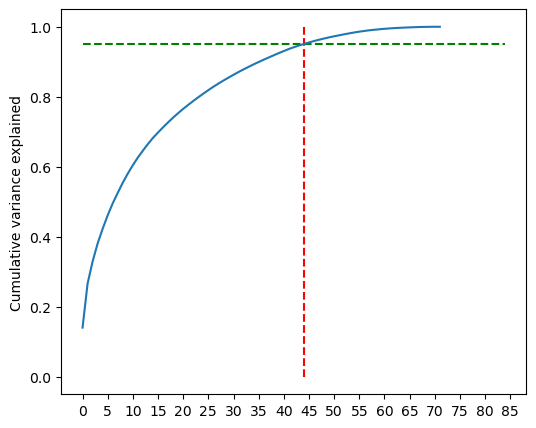

In [105]:
#PCA for undersampled dataset
pca_us = pca_scree(X_train_us,44)

**About 95% of variance is explained by 44 components**

In [106]:
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=44)
X_train_us_pca = pca_final.fit_transform(X_train_us)
X_test_us_pca = pca_final.transform(X_test)

In [107]:
X_train_us_pca.shape

(3418, 44)

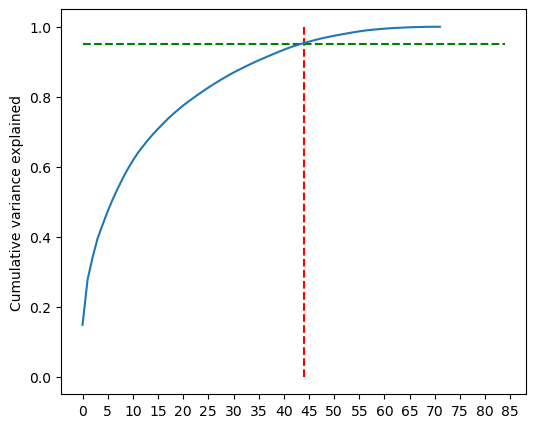

In [111]:
#PCA for SMOTE resampled dataset
pca_smote = pca_scree(X_train_smote,44)

In [112]:
#For smote resampled dataset, about 44 components explain 95% of the variance
pc_smote = IncrementalPCA(n_components=44)
X_train_smote_pca = pc_smote.fit_transform(X_train_smote)
X_test_smote_pca = pc_smote.transform(X_test)

In [113]:
X_train_smote_pca.shape

(38582, 44)

**Building Logistic Regression model for each resampled pca dataset**

In [114]:
#Defining functions for building model, predicting values and evaluating test data
def lr(X,y):
    lg = LogisticRegression(random_state=42)
    model = lg.fit(X,y)
    return model

def test_eval(X,model):
    y_test_pred = model.predict(X)
    print(classification_report(y_test,y_test_pred))

In [115]:
#Undersampling dataset
model_lr_us = lr(X_train_us_pca,y_train_us)
y_train_us_pred = model_lr_us.predict(X_train_us_pca)
print('UnderSampled:')
print(classification_report(y_train_us,y_train_us_pred))

#SMOTE dataset
model_lr_smote = lr(X_train_smote_pca,y_train_smote)
y_train_smote_pred = model_lr_smote.predict(X_train_smote_pca)
print('SMOTE:')
print(classification_report(y_train_smote,y_train_smote_pred))

UnderSampled:
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1709
           1       0.83      0.84      0.84      1709

    accuracy                           0.84      3418
   macro avg       0.84      0.84      0.84      3418
weighted avg       0.84      0.84      0.84      3418

SMOTE:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85     19291
           1       0.84      0.87      0.85     19291

    accuracy                           0.85     38582
   macro avg       0.85      0.85      0.85     38582
weighted avg       0.85      0.85      0.85     38582



In [116]:
test_eval(X_test_us_pca,model_lr_us)

              precision    recall  f1-score   support

           0       0.98      0.83      0.90      8269
           1       0.30      0.83      0.44       732

    accuracy                           0.83      9001
   macro avg       0.64      0.83      0.67      9001
weighted avg       0.93      0.83      0.86      9001



In [117]:
test_eval(X_test_smote_pca,model_lr_smote)

              precision    recall  f1-score   support

           0       0.98      0.84      0.90      8269
           1       0.31      0.83      0.45       732

    accuracy                           0.84      9001
   macro avg       0.65      0.83      0.68      9001
weighted avg       0.93      0.84      0.87      9001



**Bulding RandomForest classifier for each resampled data**

In [118]:
#Defining functions for model building and hyper parameter tuning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
def rfc():
    rf = RandomForestClassifier(random_state=42,n_jobs=-1)
    params = {
        'max_depth': range(2,50),
        'min_samples_leaf': range(20,500,40),
        'n_estimators': range(10,101,10),
        'max_features': range(5,20)
    }
    model_cv = RandomizedSearchCV(estimator=rf,
                                  param_distributions=params,
                                  verbose=1,
                                  cv=5,
                                  scoring='recall',
                                  return_train_score=True,
                                  n_jobs=-1,
                                  n_iter=50)
    return model_cv

In [119]:
#Undersampling
model_cv_us = rfc()

In [120]:
model_cv_us.fit(X_train_us_pca,y_train_us)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': range(2, 50),
                                        'max_features': range(5, 20),
                                        'min_samples_leaf': range(20, 500, 40),
                                        'n_estimators': range(10, 101, 10)},
                   return_train_score=True, scoring='recall', verbose=1)

In [121]:
model_cv_us.best_score_

0.7811476393819349

In [122]:
model_cv_us.best_estimator_

RandomForestClassifier(max_depth=48, max_features=17, min_samples_leaf=20,
                       n_estimators=70, n_jobs=-1, random_state=42)

In [123]:
model_rf_us = model_cv_us.best_estimator_

In [124]:
y_train_us_pred = model_rf_us.predict(X_train_us_pca)
print(classification_report(y_train_us,y_train_us_pred))

              precision    recall  f1-score   support

           0       0.85      0.90      0.88      1709
           1       0.90      0.85      0.87      1709

    accuracy                           0.87      3418
   macro avg       0.87      0.87      0.87      3418
weighted avg       0.87      0.87      0.87      3418



In [125]:
test_eval(X_test_us_pca,model_rf_us)

              precision    recall  f1-score   support

           0       0.98      0.85      0.91      8269
           1       0.32      0.80      0.46       732

    accuracy                           0.85      9001
   macro avg       0.65      0.82      0.68      9001
weighted avg       0.93      0.85      0.87      9001



In [126]:
#SMOTE
model_cv_smote = rfc()
model_cv_smote.fit(X_train_smote_pca,y_train_smote)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': range(2, 50),
                                        'max_features': range(5, 20),
                                        'min_samples_leaf': range(20, 500, 40),
                                        'n_estimators': range(10, 101, 10)},
                   return_train_score=True, scoring='recall', verbose=1)

In [127]:
model_rf_smote = model_cv_smote.best_estimator_

In [128]:
model_cv_smote.best_score_

0.9069511718883811

In [129]:
y_train_pred_smote = model_rf_smote.predict(X_train_smote_pca)
print(classification_report(y_train_smote,y_train_pred_smote))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94     19291
           1       0.94      0.95      0.94     19291

    accuracy                           0.94     38582
   macro avg       0.94      0.94      0.94     38582
weighted avg       0.94      0.94      0.94     38582



In [130]:
test_eval(X_test_smote_pca,model_rf_smote)

              precision    recall  f1-score   support

           0       0.97      0.92      0.94      8269
           1       0.43      0.69      0.53       732

    accuracy                           0.90      9001
   macro avg       0.70      0.81      0.74      9001
weighted avg       0.93      0.90      0.91      9001



## Model Evaluation

**There are 4 models:**
   1. **model_lr_us** - *Logistic Regression model on Undersampled Data*
   2. **model_lr_smote** - *Logistic Regression model on SMOTE Data*
   3. **model_rf_us** - *RandomForest Classifier on Undersampled Data*
   4. **model_rf_smote** - *RandomForest Classifier on SMOTE data*

In [136]:
#Defining function to display evaluation metrics
from sklearn.metrics import accuracy_score,recall_score,precision_score
import sklearn.metrics as metrics
def eval(X_train,y_train,X_test,model,title):
    y_train_pred = model.predict(X_train)
    confusion_train = confusion_matrix(y_train,y_train_pred)
    acc_train = accuracy_score(y_train,y_train_pred)
    recall_train = recall_score(y_train,y_train_pred)
    precision_train = precision_score(y_train,y_train_pred)
    f1_train = metrics.f1_score(y_train,y_train_pred)
    y_test_pred = model.predict(X_test)
    confusion_test = confusion_matrix(y_test,y_test_pred)
    acc_test = round(accuracy_score(y_test,y_test_pred),2)
    recall_test = round(recall_score(y_test,y_test_pred),2)
    precision_test = round(precision_score(y_test,y_test_pred),2)
    f1_test = round(metrics.f1_score(y_test,y_test_pred),2)
    print('\t\tTrain Data\t\t\t\t\t\t\tTest Data\n')
    print('\trecall:    ',recall_train,'\t\t\t\t\t','recall:    ',recall_test)
    print('\taccuracy:  ',acc_train,'\t\t\t\t\t','accuracy:  ',acc_test)
    print('\tprecision: ',precision_train,'\t\t\t\t\t','precision: ',precision_test)
    print('\tF1-score:  ',f1_train,'\t\t\t\t\t','F1-score:  ',f1_test)
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 3),gridspec_kw={'wspace':0.8})
    plt.sca(ax1)
    sns.heatmap(confusion_train,annot=True,fmt='.0f')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.sca(ax2)
    sns.heatmap(confusion_test,annot=True,fmt='.0f')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()

		Train Data							Test Data

	recall:     0.8402574605032183 					 recall:     0.83
	accuracy:   0.8367466354593329 					 accuracy:   0.83
	precision:  0.8343986054619408 					 precision:  0.3
	F1-score:   0.8373177842565598 					 F1-score:   0.44


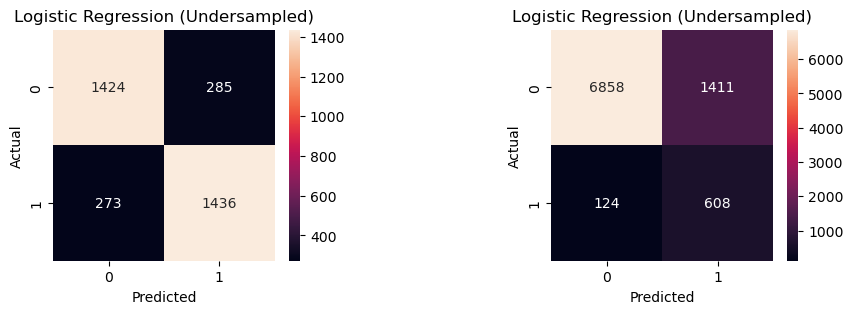

In [137]:
eval(X_train_us_pca,y_train_us,X_test_us_pca,model_lr_us,'Logistic Regression (Undersampled)')

		Train Data							Test Data

	recall:     0.8651702866621741 					 recall:     0.83
	accuracy:   0.8524959825825514 					 accuracy:   0.84
	precision:  0.8437815975733064 					 precision:  0.31
	F1-score:   0.8543420951600933 					 F1-score:   0.45


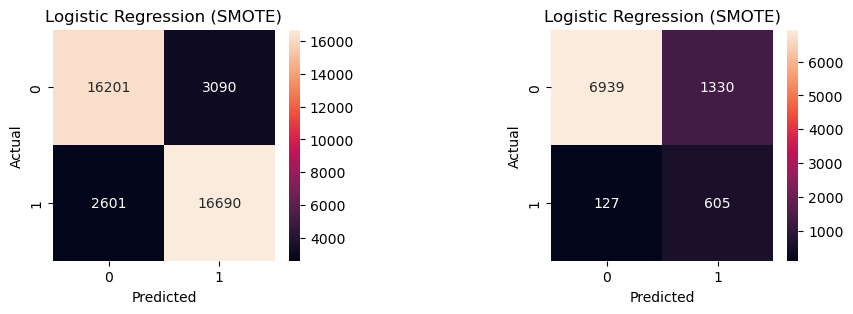

In [138]:
eval(X_train_smote_pca,y_train_smote,X_test_smote_pca,model_lr_smote,'Logistic Regression (SMOTE)')

		Train Data							Test Data

	recall:     0.8455236980690463 					 recall:     0.8
	accuracy:   0.8736102984201287 					 accuracy:   0.85
	precision:  0.8958462492250465 					 precision:  0.32
	F1-score:   0.8699578567128237 					 F1-score:   0.46


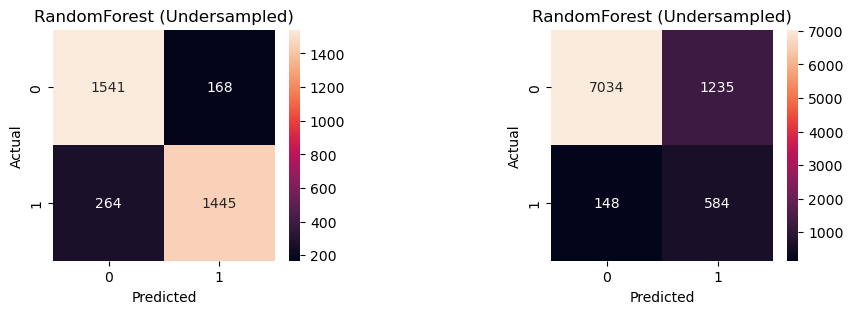

In [139]:
eval(X_train_us_pca,y_train_us,X_test_us_pca,model_rf_us,'RandomForest (Undersampled)')

		Train Data							Test Data

	recall:     0.9479550049245762 					 recall:     0.69
	accuracy:   0.9434710486755482 					 accuracy:   0.9
	precision:  0.9395293875873407 					 precision:  0.43
	F1-score:   0.9437233905302541 					 F1-score:   0.53


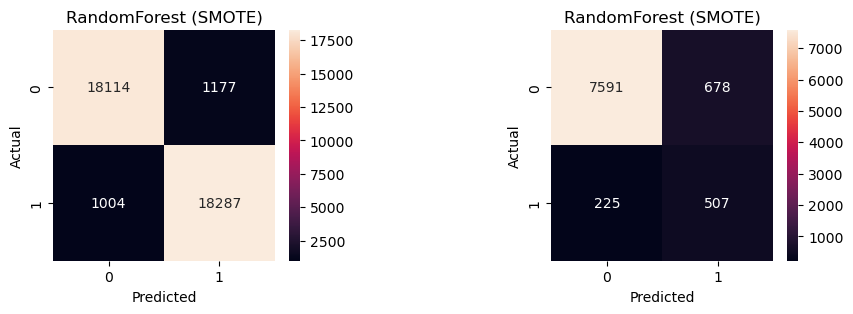

In [140]:
eval(X_train_smote_pca,y_train_smote,X_test_smote_pca,model_rf_smote,'RandomForest (SMOTE)')

**From the above evaluation metrics:**

overall performance of SOMTE resampled data with Logistic regression performs the best with following metrics:
   * recall:    0.83
   * accuracy:  0.83
   * precision: 0.31
   * F1-score:  0.45

In [141]:
#Best model
model_lr_smote

LogisticRegression(random_state=42)

## Understanding Feature importance

**Using Logistic Regression for identifying feature importance**

In [142]:
#New variable name for trainnig and testing data
X_train_lr = X_train_smote
X_test_lr = X_test
print('train: ',X_train_lr.shape)
print('test:  ',X_test_lr.shape)

train:  (38582, 72)
test:   (9001, 72)


**The training and testing datasets are:**
   1. **X_train_lr** and **y_train_smote**
   2. **X_test_lr** and **y_test**

### Feature Selection using RFE

In [184]:
from sklearn.feature_selection import RFE
lg = LogisticRegression()
rfe = RFE(lg,n_features_to_select=15)
rfe = rfe.fit(X_train_lr,y_train_smote)

In [185]:
list(zip(X_train_lr.columns,rfe.support_,rfe.ranking_))

[('arpu_8', False, 11),
 ('offnet_mou_8', False, 6),
 ('roam_og_mou_8', True, 1),
 ('loc_og_t2t_mou_8', False, 25),
 ('loc_og_t2m_mou_8', True, 1),
 ('loc_og_t2f_mou_8', False, 50),
 ('loc_og_t2c_mou_8', False, 47),
 ('std_og_t2t_mou_8', False, 5),
 ('std_og_t2m_mou_8', False, 22),
 ('std_og_t2f_mou_8', False, 2),
 ('std_og_mou_8', False, 7),
 ('isd_og_mou_8', False, 38),
 ('spl_og_mou_8', False, 55),
 ('og_others_8', False, 58),
 ('total_og_mou_8', False, 44),
 ('loc_ic_t2t_mou_8', False, 8),
 ('loc_ic_t2f_mou_8', True, 1),
 ('std_ic_t2t_mou_8', False, 24),
 ('std_ic_t2f_mou_8', False, 36),
 ('std_ic_mou_8', False, 23),
 ('total_ic_mou_8', True, 1),
 ('spl_ic_mou_8', True, 1),
 ('isd_ic_mou_8', False, 28),
 ('ic_others_8', False, 51),
 ('total_rech_num_8', True, 1),
 ('max_rech_amt_8', False, 32),
 ('last_day_rch_amt_8', True, 1),
 ('max_rech_data_8', False, 42),
 ('vol_2g_mb_8', True, 1),
 ('vol_3g_mb_8', True, 1),
 ('monthly_2g_8', True, 1),
 ('sachet_2g_8', True, 1),
 ('monthly_3g_

In [186]:
cols = X_train_lr.columns[rfe.support_]

### Model Building using GLM

In [187]:
#Defining functions for model building and VIF
import statsmodels.api as sm
def lgr_model(X_sm):
    lgr = sm.GLM(y_train_smote,X_sm, family=sm.families.Binomial())
    model = lgr.fit()
    return model

from statsmodels.stats.outliers_influence import variance_inflation_factor
def vif(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

def eval_train(X_sm,model):
    y_train_sm_pred = model.predict(X_sm).values.reshape(-1)
    y_train_sm_pred_final = pd.DataFrame({'Churn':y_train_smote.values,'Churn_prob':y_train_sm_pred})
    return y_train_sm_pred_final
def eval_test(X_sm,model):
    y_test_sm_pred = model.predict(X_sm).values.reshape(-1)
    y_test_sm_pred_final = pd.DataFrame({'Churn':y_test.values,'Churn_prob':y_test_sm_pred})
    return y_test_sm_pred_final

In [188]:
X_train_lr_sm = sm.add_constant(X_train_lr[cols])
model1 = lgr_model(X_train_lr_sm)
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                38582
Model:                            GLM   Df Residuals:                    38566
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14315.
Date:                Tue, 09 Jan 2024   Deviance:                       28631.
Time:                        20:58:32   Pearson chi2:                 9.13e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4749
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.8411      0.026    -71.469      0.000      -1.892      -1.791
roam_og_mou_8          0.2703      0.014     19.493      0.000       0.243       0.298
loc_og_t2m_mou_8      -0.6390      0.033    -19.659      0.000      -0.703      -0.575
loc_ic_t2f_mou_8      -0.2681      0.029     -9.180      0.000      -0.325      -0.211
total_ic_mou_8        -1.1233      0.044    -25.570      0.000      -1.209      -1.037
spl_ic_mou_8          -0.5890      0.030    -19.703      0.000      -0.648      -0.530
total_rech_num_8      -0.8056      0.021    -37.579      0.000      -0.848      -0.764
last_day_rch_amt_8    -0.7109      0.019    -36.668      0.000      -0.749      -0.673
vol_2g_mb_8           -0.3461      0.027    -12.781      0.000      -0.399      -0.293
vol_3g_mb_8           -0.2945      0.027    -11.083      0.000      -0.347      -0.242
monthly_2g_8          -0.3216      0.027    -11.755      0.000      -0.375      -0.268
sachet_2g_8           -0.3624      0.026    -13.770      0.000      -0.414      -0.311
aon                   -0.3452      0.019    -18.141      0.000      -0.382      -0.308
vbc_3g_8              -0.3324      0.030    -11.038      0.000      -0.391      -0.273
arpu_gh                0.4133      0.019     21.635      0.000       0.376       0.451
total_ic_mou_gh        0.4081      0.031     13.185      0.000       0.347       0.469
======================================================================================
"""

In [189]:
vif(X_train_lr[cols])

Features   VIF
3       total_ic_mou_8  4.59
14     total_ic_mou_gh  2.71
1     loc_og_t2m_mou_8  2.29
8          vol_3g_mb_8  2.28
12            vbc_3g_8  2.19
5     total_rech_num_8  1.71
2     loc_ic_t2f_mou_8  1.61
10         sachet_2g_8  1.60
6   last_day_rch_amt_8  1.53
7          vol_2g_mb_8  1.52
9         monthly_2g_8  1.40
13             arpu_gh  1.38
11                 aon  1.24
0        roam_og_mou_8  1.12
4         spl_ic_mou_8  1.07

**Model 2**

In [190]:
#remove column total_ic_mou_8 since its vif is more than 3
cols = cols.drop('total_ic_mou_8')
X_train_lr_sm = sm.add_constant(X_train_lr[cols])
model2 = lgr_model(X_train_lr_sm)
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                38582
Model:                            GLM   Df Residuals:                    38567
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14708.
Date:                Tue, 09 Jan 2024   Deviance:                       29415.
Time:                        20:58:33   Pearson chi2:                 8.99e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4641
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.7831      0.025    -70.546      0.000      -1.833      -1.734
roam_og_mou_8          0.3019      0.014     22.106      0.000       0.275       0.329
loc_og_t2m_mou_8      -0.9847      0.031    -31.500      0.000      -1.046      -0.923
loc_ic_t2f_mou_8      -0.4634      0.028    -16.656      0.000      -0.518      -0.409
spl_ic_mou_8          -0.6219      0.030    -20.615      0.000      -0.681      -0.563
total_rech_num_8      -0.9721      0.021    -46.686      0.000      -1.013      -0.931
last_day_rch_amt_8    -0.7966      0.019    -41.795      0.000      -0.834      -0.759
vol_2g_mb_8           -0.3628      0.027    -13.529      0.000      -0.415      -0.310
vol_3g_mb_8           -0.3083      0.027    -11.633      0.000      -0.360      -0.256
monthly_2g_8          -0.3287      0.027    -12.132      0.000      -0.382      -0.276
sachet_2g_8           -0.3498      0.026    -13.352      0.000      -0.401      -0.298
aon                   -0.3389      0.019    -18.250      0.000      -0.375      -0.302
vbc_3g_8              -0.3829      0.030    -12.777      0.000      -0.442      -0.324
arpu_gh                0.4774      0.019     25.493      0.000       0.441       0.514
total_ic_mou_gh       -0.1121      0.021     -5.359      0.000      -0.153      -0.071
======================================================================================
"""

In [191]:
vif(X_train_lr[cols])

Features   VIF
7          vol_3g_mb_8  2.28
11            vbc_3g_8  2.18
1     loc_og_t2m_mou_8  1.94
9          sachet_2g_8  1.60
13     total_ic_mou_gh  1.60
4     total_rech_num_8  1.57
6          vol_2g_mb_8  1.52
2     loc_ic_t2f_mou_8  1.49
5   last_day_rch_amt_8  1.48
8         monthly_2g_8  1.40
12             arpu_gh  1.35
10                 aon  1.24
0        roam_og_mou_8  1.11
3         spl_ic_mou_8  1.07

**All p-value and vif are within the acceptable range, hence we will finalize model 2**

In [192]:
y_train_sm_df = eval_train(X_train_lr_sm,model2)

In [193]:
y_train_sm_df['Predicted'] = y_train_sm_df.Churn_prob.map(lambda x: 1 if x > 0.5 else 0)

In [194]:
y_train_sm_df.head()

Churn  Churn_prob  Predicted
0      0    0.126530          0
1      0    0.094185          0
2      0    0.374958          0
3      0    0.232715          0
4      0    0.811086          1

In [195]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

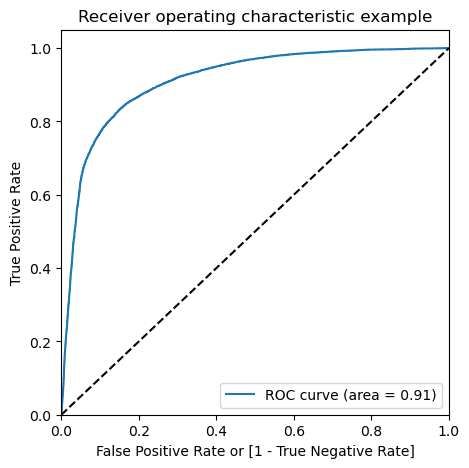

ROC_AUC_SCORE: 0.91


In [196]:
draw_roc(y_train_sm_df.Churn,y_train_sm_df.Churn_prob)
print('ROC_AUC_SCORE: {:2.2f}'.format(metrics.roc_auc_score(y_train_sm_df.Churn,y_train_sm_df.Churn_prob)))

In [197]:
X_test_lr_sm = sm.add_constant(X_test_lr[cols])
y_test_sm_df = eval_test(X_test_lr_sm,model2)

In [198]:
y_test_sm_df['Predicted'] = y_test_sm_df.Churn_prob.map(lambda x: 1 if x > 0.5 else 0)

In [199]:
y_test_sm_df.head()

Churn  Churn_prob  Predicted
0      0    0.898209          1
1      0    0.125069          0
2      0    0.147907          0
3      0    0.390808          0
4      0    0.058453          0

In [183]:
print('Train: ')
print('recall:    ',round(recall_score(y_train_sm_df.Churn,y_train_sm_df.Predicted),2))
print('accuracy:  ',round(accuracy_score(y_train_sm_df.Churn,y_train_sm_df.Predicted),2))
print('precision: ',round(precision_score(y_train_sm_df.Churn,y_train_sm_df.Predicted),2))
print('f1-score:  ',round(metrics.f1_score(y_train_sm_df.Churn,y_train_sm_df.Predicted),2))
print('\nTest: ')
print('recall:    ',round(recall_score(y_test_sm_df.Churn,y_test_sm_df.Predicted),2))
print('accuracy:  ',round(accuracy_score(y_test_sm_df.Churn,y_test_sm_df.Predicted),2))
print('precision: ',round(precision_score(y_test_sm_df.Churn,y_test_sm_df.Predicted),2))
print('f1-score:  ',round(metrics.f1_score(y_test_sm_df.Churn,y_test_sm_df.Predicted),2))

Train: 
recall:     0.85
accuracy:   0.83
precision:  0.82
f1-score:   0.83

Test: 
recall:     0.79
accuracy:   0.81
precision:  0.27
f1-score:   0.4


**The initiall model performs well with no p-value greater than 0.05 and no high vif**
   * The performance metrics for the model are:
      * recall: 0.82
      * accuracy: 0.82
      * precision: 0.29
      * f1-score: 0.42
      * roc_auc_score = 0.91

**Visualizing feature importance**

In [200]:
coef_df = pd.DataFrame(model2.params[1:]).reset_index()
coef_df = coef_df.rename(columns={'index':'feature',0:'coef'})
coef_df

feature      coef
0        roam_og_mou_8  0.301887
1     loc_og_t2m_mou_8 -0.984726
2     loc_ic_t2f_mou_8 -0.463363
3         spl_ic_mou_8 -0.621892
4     total_rech_num_8 -0.972097
5   last_day_rch_amt_8 -0.796558
6          vol_2g_mb_8 -0.362806
7          vol_3g_mb_8 -0.308291
8         monthly_2g_8 -0.328707
9          sachet_2g_8 -0.349782
10                 aon -0.338855
11            vbc_3g_8 -0.382920
12             arpu_gh  0.477445
13     total_ic_mou_gh -0.112087

<Axes: ylabel='feature'>

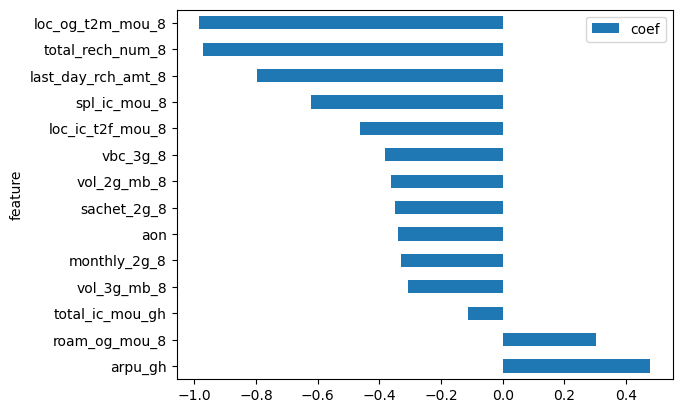

In [201]:
coef_df.sort_values(by='coef',ascending=False).plot.barh(x='feature')

In [202]:
#absolute feature importance
coef_df.coef = np.abs(coef_df.coef)
coef_df.sort_values(by='coef',ascending=False)

feature      coef
1     loc_og_t2m_mou_8  0.984726
4     total_rech_num_8  0.972097
5   last_day_rch_amt_8  0.796558
3         spl_ic_mou_8  0.621892
12             arpu_gh  0.477445
2     loc_ic_t2f_mou_8  0.463363
11            vbc_3g_8  0.382920
6          vol_2g_mb_8  0.362806
9          sachet_2g_8  0.349782
10                 aon  0.338855
8         monthly_2g_8  0.328707
7          vol_3g_mb_8  0.308291
0        roam_og_mou_8  0.301887
13     total_ic_mou_gh  0.112087

### Strategies to manage Customer Churn

1. Customers having high roaming minutes of usage tend to churn, providing good discounts on roaming charges can help
2. Decrease in the average revenue per user from the good phase to action phase is another indicator of churn
3. Focus marketing strategies on relatively new customers can reduce churn, since customers with less age on network tend to churn more
4. Higher minutes of usage on local outgoing calls from operator T to other operator mobile indicates high probability of churn.
5. Using attractive discounts, and competitive rates for customer with decreasing or highly variable minutes of usage on local, std, isd, and spl sevices may reduce the probability of churn